### Data exploration and preprocessing for the [...] dataset

In [1]:
"""
Load the source dataset and preprocess it

__ imgs
    |
    |__ fold_1
          |__ datasetname_id.png
          |__ ...
    |__ fold_2
          |__ datasetname_id.png
          |__ ...
    |__ fold_3
          |__ datasetname_id.png
          |__ ...
    |__ fold_4
          |__ datasetname_id.png
          |__ ...
          |__ datasetname_id.png
          |__ ...

__ masks
    |
    |__ fold_1
          |__ datasetname_id.png  --> segmentation mask
          |__ datasetname_id.json --> segmentation box (COCO format)
          |__ ...
    |__ fold_2
          |__ datasetname_id.png
          |__ datasetname_id.json
          |__ ...
    |__ fold_3
          |__ datasetname_id.png
          |__ datasetname_id.json
          |__ ...
    |__ fold_4
          |__ datasetname_id.png
          |__ datasetname_id.json
          |__ ...
    |__ fold_5
          |__ datasetname_id.png
          |__ datasetname_id.json
          |__ ...

For segmentation masks --> 0 and 1 (if more than 2 labels --> use SimpleITK to encode integers in images)
For segmentation boxes --> use the COCO format to encode boxes
"""

'\nLoad the source dataset and preprocess it\n\n__ imgs\n    |\n    |__ fold_1\n          |__ datasetname_id.png\n          |__ ...\n    |__ fold_2\n          |__ datasetname_id.png\n          |__ ...\n    |__ fold_3\n          |__ datasetname_id.png\n          |__ ...\n    |__ fold_4\n          |__ datasetname_id.png\n          |__ ...\n          |__ datasetname_id.png\n          |__ ...\n\n__ masks\n    |\n    |__ fold_1\n          |__ datasetname_id.png  --> segmentation mask\n          |__ datasetname_id.json --> segmentation box (COCO format)\n          |__ ...\n    |__ fold_2\n          |__ datasetname_id.png\n          |__ datasetname_id.json\n          |__ ...\n    |__ fold_3\n          |__ datasetname_id.png\n          |__ datasetname_id.json\n          |__ ...\n    |__ fold_4\n          |__ datasetname_id.png\n          |__ datasetname_id.json\n          |__ ...\n    |__ fold_5\n          |__ datasetname_id.png\n          |__ datasetname_id.json\n          |__ ...\n\nFor segm

In [2]:
import os
import zipfile
import random
import shutil
from PIL import Image
from tqdm import tqdm
import json 
from PIL import ImageDraw

import matplotlib.pyplot as plt
import numpy as np

from helpers import check_dir_consistency, visualize_images, get_all_dims, create_histograms_of_dims

Please follow the suggested of download order.

## 1. Train
### 1.1 Original images from DOTA v1
- Get the 'image' folder from https://drive.google.com/drive/folders/1gmeE3D7R62UAtuIFOB9j2M5cUPTwtsxK
- 3 zips in total (1411 images):
    - `part1.zip` (469 images)
    - `part2.zip` (474 images)
    - `part3.zip` (468 images)
- Note: do not take '~1/part1.zip' in addition to '~part1.zip'

### 1.2 Masks from isaid
- Get all folders from https://drive.google.com/drive/folders/19RPVhC0dWpLF9Y_DYjxjUrwLbKUBQZ2K
- 1 zip `train-20240131T084536Z-001.zip`


## 2. Valid
### 2.1. Original images from DOTA v1
- Get the 'image' folder from https://drive.google.com/drive/folders/1RV7Z5MM4nJJJPUs6m9wsxDOJxX6HmQqZ
- 1 zip file (458 images): 
    - `part1.zip` (458 images)
- If you have followed suggested download order, this file should be renamed by your operating system (e.g., `part1 (1).zip`)
### 2.2. Masks from isaid
- Get all folders from https://drive.google.com/drive/folders/17MErPhWQrwr92Ca1Maf4mwiarPS5rcWM
- 1 zip `val-20240131T084706Z-001.zip`

## 3. Test
Download is not needed given that annotations of the test set are not publicly available.

There are a total of 1869 images for which annotations are provided.
The remaining 937 images from the test set are not used.

## Prepare data

In [3]:
seed = 42
nb_folds = 5

### Directories

In [4]:
input_dir = '/home/rob/Documents/3_projects/bench/isaid/data' # <--- modify this
output_dir = '/home/rob/Documents/3_projects/bench/isaid/processed' # <--- modify this

file_names = os.listdir(input_dir)
file_names

['part1 (1).zip',
 'part2.zip',
 'part1.zip',
 'part3.zip',
 'val-20240131T084706Z-001.zip',
 'train-20240131T084536Z-001.zip']

In [5]:
data_sources = [os.path.join(input_dir, f) for f in file_names]
print(f'Data file location: {data_sources}')

Data file location: ['/home/rob/Documents/3_projects/bench/isaid/data/part1 (1).zip', '/home/rob/Documents/3_projects/bench/isaid/data/part2.zip', '/home/rob/Documents/3_projects/bench/isaid/data/part1.zip', '/home/rob/Documents/3_projects/bench/isaid/data/part3.zip', '/home/rob/Documents/3_projects/bench/isaid/data/val-20240131T084706Z-001.zip', '/home/rob/Documents/3_projects/bench/isaid/data/train-20240131T084536Z-001.zip']


In [6]:
tmp_data_dir = os.path.join(output_dir, 'tmp_data')
os.makedirs(tmp_data_dir, exist_ok=True)
print(tmp_data_dir)

/home/rob/Documents/3_projects/bench/isaid/processed/tmp_data


In [7]:
def unzip_dirs(data_sources: str, tmp_data_dir: str) -> list:
    subdirs: list = []

    for data_source in tqdm(data_sources, desc='Unzip dir'):
        subdir_name = os.path.splitext(os.path.basename(data_source))[0]
        subdir_path = os.path.join(tmp_data_dir, subdir_name)
        subdirs.append(subdir_path)

        # Make destination dir
        os.makedirs(subdir_path, exist_ok=True)
        
        # Unzip
        with zipfile.ZipFile(data_source, 'r') as zip_file:
            print(f'Unzipping {data_source} into {subdir_path}')
            zip_file.extractall(subdir_path)

        # Clear new dir
        images_dir = os.path.join(subdir_path, 'images')
        if os.path.exists(images_dir):
            # Move all images one directory higher in dir tree
            for file_name in os.listdir(images_dir):
                shutil.move(os.path.join(images_dir, file_name), subdir_path)
            # Remove empty 'image' subdirectory
            os.rmdir(images_dir)
    return subdirs

subdirs = unzip_dirs(data_sources)

Unzip dir:   0%|          | 0/6 [00:00<?, ?it/s]

Unzipping /home/rob/Documents/3_projects/bench/isaid/data/part1 (1).zip into /home/rob/Documents/3_projects/bench/isaid/processed/tmp_data/part1 (1)


Unzip dir:  17%|█▋        | 1/6 [00:30<02:32, 30.48s/it]

Unzipping /home/rob/Documents/3_projects/bench/isaid/data/part2.zip into /home/rob/Documents/3_projects/bench/isaid/processed/tmp_data/part2


Unzip dir:  33%|███▎      | 2/6 [01:10<02:24, 36.09s/it]

Unzipping /home/rob/Documents/3_projects/bench/isaid/data/part1.zip into /home/rob/Documents/3_projects/bench/isaid/processed/tmp_data/part1


Unzip dir:  50%|█████     | 3/6 [01:32<01:28, 29.63s/it]

Unzipping /home/rob/Documents/3_projects/bench/isaid/data/part3.zip into /home/rob/Documents/3_projects/bench/isaid/processed/tmp_data/part3


Unzip dir:  67%|██████▋   | 4/6 [02:05<01:02, 31.11s/it]

Unzipping /home/rob/Documents/3_projects/bench/isaid/data/val-20240131T084706Z-001.zip into /home/rob/Documents/3_projects/bench/isaid/processed/tmp_data/val-20240131T084706Z-001


Unzip dir:  83%|████████▎ | 5/6 [02:06<00:20, 20.19s/it]

Unzipping /home/rob/Documents/3_projects/bench/isaid/data/train-20240131T084536Z-001.zip into /home/rob/Documents/3_projects/bench/isaid/processed/tmp_data/train-20240131T084536Z-001


Unzip dir: 100%|██████████| 6/6 [02:08<00:00, 21.45s/it]


###

In [ ]:
annotation_file_train = os.path.join(output_dir, 'tmp_data/train-20240131T084536Z-001/train/Annotations/iSAID_train.json')
annotation_file_valid = os.path.join(output_dir, 'tmp_data/val-20240131T084706Z-001/val/Annotations/iSAID_val.json')

In [8]:
def rename_masks(dir, file_format: str = 'png'):
    """
    Renames files in a given directory by removing a specified suffix from their names.

    Args:
    dir (str): The path to the directory containing the files to be renamed.
    file_format (str): The extension of the file (e.g. 'png', 'jpeg')

    This function iterates over all files in the specified directory.
    The function does not return any value but renames the files in place.
    """
    if not os.path.exists(dir):
        raise Exception(f"Directory does not exist: {dir}")

    for filename in os.listdir(dir):
        file_path = os.path.join(dir, filename)

        if os.path.isfile(file_path):
            # Only keep prefix of image names (i.e., remove '_instance_color_RGB')
            new_name = filename.split('_')[0] + '.' + file_format
            new_file_path = os.path.join(dir, new_name)

            os.rename(file_path, new_file_path)

In [9]:
def move_dir(source: str, destination: str):
    # Create destination directory if needed
    os.makedirs(destination, exist_ok=True)

    if not os.path.exists(source):
        print(f"Directory does not exist : {source}")
        return

    # Move all images to destination
    for item in tqdm(os.listdir(source), 'moving files'):
        source_item = os.path.join(source, item)
        destination_item = os.path.join(destination, item)

        if os.path.isfile(source_item):
            shutil.move(source_item, destination_item)

In [10]:
def unzip_and_move_masks(tmp_data_dir, semantic_masks, mask_dir, subdir):
    dataset_type = os.path.basename(subdir.split('-')[0]) # train or val
    if semantic_masks:
        annotation_type = 'Semantic_masks' 
    else:
        annotation_type = 'Instance_masks'
    annotation_dir_name = f'{dataset_type}_{annotation_type}'
    annotation_dir = os.path.join(tmp_data_dir, annotation_dir_name) 

    os.makedirs(annotation_dir, exist_ok=True)
    source_dir = os.path.join(subdir, f'{dataset_type}/{annotation_type}/images.zip')
            
    # Unzip
    with zipfile.ZipFile(source_dir, 'r') as zip_file:
        print(f'Unzipping {source_dir} into {annotation_dir}')
        zip_file.extractall(annotation_dir)
            
    # Clear new dir
    images_dir = os.path.join(annotation_dir, 'images')
    if os.path.exists(images_dir):
        # Move all images one directory higher in dir tree
        for file_name in os.listdir(images_dir):
            shutil.move(os.path.join(images_dir, file_name), annotation_dir)
        os.rmdir(images_dir) # Remove empty 'image' subdirectory

    # Rename masks 
    rename_masks(annotation_dir)
    move_dir(annotation_dir, mask_dir)

In [11]:
# Create list of image directories, and list of annotation directories
def get_img_and_mask_dir(subdirs: str, tmp_data_dir: str, semantic_masks: bool = True) -> tuple:
    img_dir: str = os.path.join(tmp_data_dir, 'imgs')
    mask_dir: str = os.path.join(tmp_data_dir, 'masks')

    for subdir in subdirs:
        subdir_name = os.path.basename(subdir)

        # Collect dir name for images and move them into a unique imgs directory
        if subdir_name.startswith('part'):
            move_dir(subdir, img_dir)
        # Unzip annotation directories and clear them
        else: 
            unzip_and_move_masks(tmp_data_dir, semantic_masks, mask_dir, subdir)

    return img_dir, mask_dir

In [12]:
img_dir, mask_dir = get_img_and_mask_dir(subdirs, tmp_data_dir, semantic_masks=True)
img_files, mask_files = check_dir_consistency(img_dir, mask_dir)

moving files: 100%|██████████| 468/468 [00:00<00:00, 30068.08it/s]


Unzipping /home/rob/Documents/3_projects/bench/isaid/processed/tmp_data/val-20240131T084706Z-001/val/Semantic_masks/images.zip into /home/rob/Documents/3_projects/bench/isaid/processed/tmp_data/val_Semantic_masks


moving files: 100%|██████████| 458/458 [00:00<00:00, 31474.63it/s]


Unzipping /home/rob/Documents/3_projects/bench/isaid/processed/tmp_data/train-20240131T084536Z-001/train/Semantic_masks/images.zip into /home/rob/Documents/3_projects/bench/isaid/processed/tmp_data/train_Semantic_masks


moving files: 100%|██████████| 1411/1411 [00:00<00:00, 30001.54it/s]

All images have a matching mask.


### Visualize Data

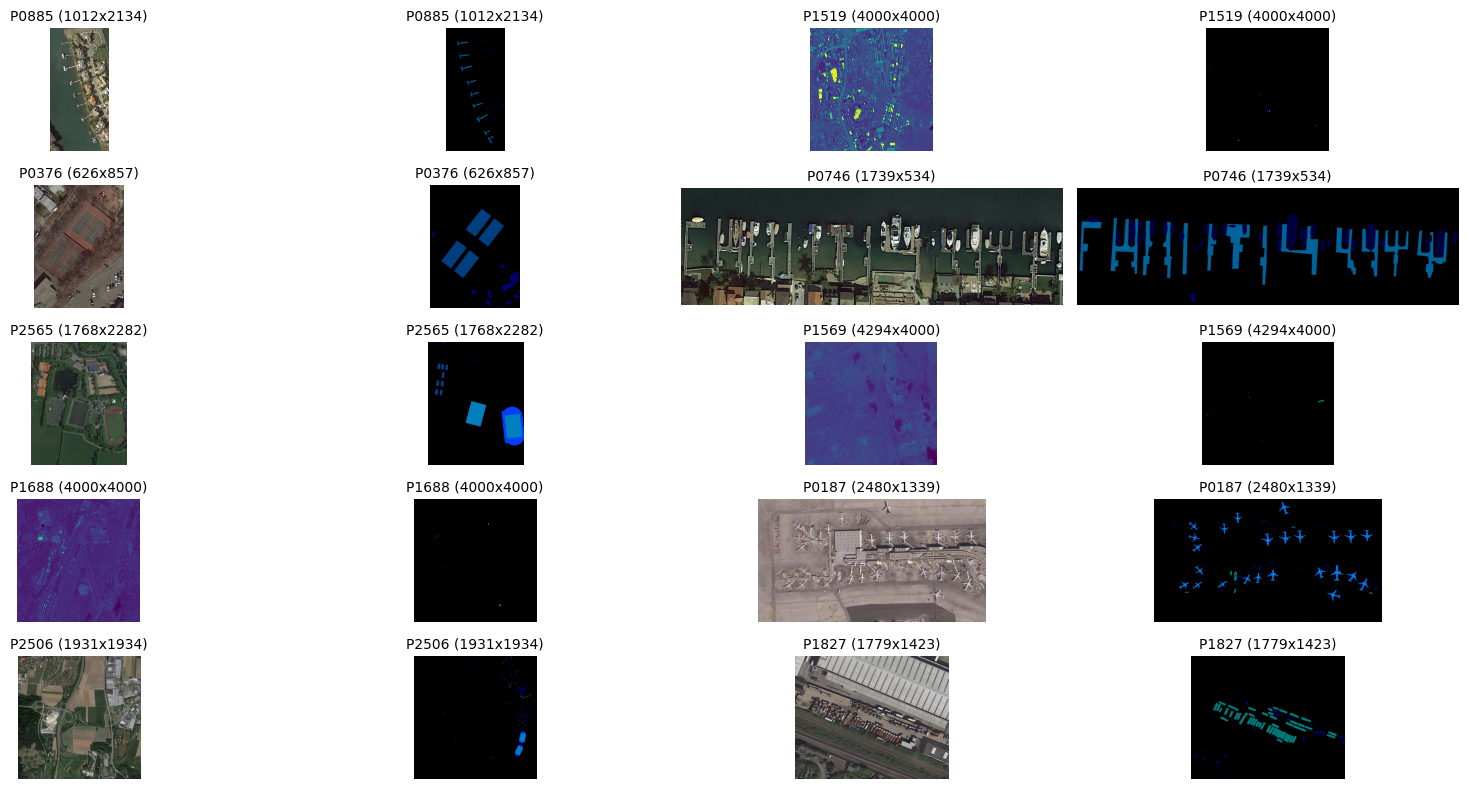

In [13]:
visualize_images(img_dir, mask_dir, seed=seed)

In [14]:
all_dims = get_all_dims(img_dir)

Number of unique dimensions in images: 1548


In [15]:
min_width = min(dim[0] for dim in all_dims)
min_height = min(dim[1] for dim in all_dims)
print(f"Minimum width: {min_width}")
print(f"Minimum height: {min_height}")

Minimum width: 353
Minimum height: 278


bin size: 43


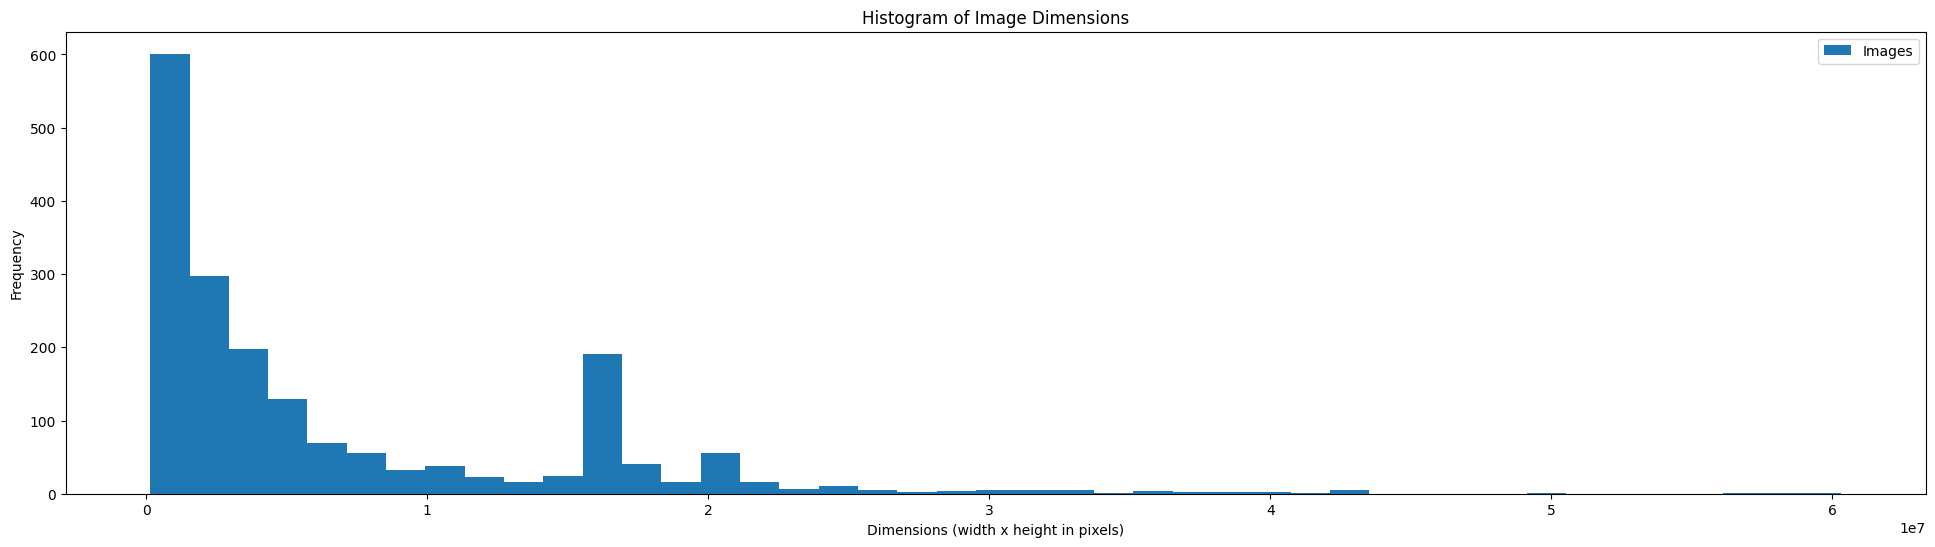

In [16]:
create_histograms_of_dims(img_dir, mult=True)

In [17]:
#create_histograms_of_dims(img_dir)

In [18]:
def count_images_below_threshold(img_dir, threshold: int = 448):
    count = 0
    images_too_small: list = []

    for img_file in os.listdir(img_dir):
        file_path = os.path.join(img_dir, img_file)

        # Open image and get dim
        try:
            with Image.open(file_path) as img:
                width, height = img.size
                if width < threshold or height < threshold:
                    count += 1
                    images_too_small.append(file_path)
        except IOError:
            print(f"Cannot open the file: {file_path}")

    return count, images_too_small

patch_size = 448
num_images_too_small, img_too_small = count_images_below_threshold(img_dir, threshold=patch_size)
num_mask_too_small, mask_too_small = count_images_below_threshold(mask_dir, threshold=patch_size)
print(f'Found {num_images_too_small} images and {num_mask_too_small} masks below threhsold.')

# Remove images and masks
if num_images_too_small == num_images_too_small:
    [os.remove(img) for img in img_too_small]
    [os.remove(img) for img in mask_too_small]
else:
    raise Exception(f"There is a mismatch between your images and masks!")

Found 20 images and 20 masks below threhsold.


In [19]:
n_patches = 30
output_imgs = os.path.join(tmp_data_dir, 'imgs_patches')
output_masks = os.path.join(tmp_data_dir, 'masks_patches')

[os.makedirs(dir, exist_ok=True) for dir in [output_imgs, output_masks]]

[None, None]

## Process annotations

In [20]:
# Load json
with open(annotation_file_train, 'r') as f:
    metadata: dict = json.load(f)

# Show metadata content
[k for k in metadata]

['images', 'categories', 'annotations']

In [21]:
categories: dict = metadata['categories']
categories

[{'id': 1, 'name': 'storage_tank'},
 {'id': 2, 'name': 'Large_Vehicle'},
 {'id': 3, 'name': 'Small_Vehicle'},
 {'id': 4, 'name': 'plane'},
 {'id': 5, 'name': 'ship'},
 {'id': 6, 'name': 'Swimming_pool'},
 {'id': 7, 'name': 'Harbor'},
 {'id': 8, 'name': 'tennis_court'},
 {'id': 9, 'name': 'Ground_Track_Field'},
 {'id': 10, 'name': 'Soccer_ball_field'},
 {'id': 11, 'name': 'baseball_diamond'},
 {'id': 12, 'name': 'Bridge'},
 {'id': 13, 'name': 'basketball_court'},
 {'id': 14, 'name': 'Roundabout'},
 {'id': 15, 'name': 'Helicopter'}]

In [22]:
# Show what annotations look like
annotations = metadata['annotations']
annotations[0]

{'id': 0,
 'image_id': 0,
 'segmentation': [[274,
   1602,
   273,
   1603,
   272,
   1603,
   271,
   1603,
   270,
   1604,
   269,
   1604,
   268,
   1604,
   267,
   1604,
   266,
   1605,
   265,
   1605,
   264,
   1605,
   263,
   1606,
   262,
   1606,
   261,
   1606,
   260,
   1607,
   259,
   1607,
   258,
   1607,
   257,
   1608,
   256,
   1608,
   255,
   1608,
   254,
   1609,
   253,
   1610,
   252,
   1611,
   251,
   1611,
   250,
   1612,
   249,
   1613,
   249,
   1614,
   248,
   1615,
   247,
   1616,
   246,
   1617,
   246,
   1618,
   245,
   1619,
   244,
   1620,
   244,
   1621,
   244,
   1622,
   244,
   1623,
   244,
   1624,
   244,
   1625,
   244,
   1626,
   244,
   1627,
   244,
   1628,
   244,
   1629,
   244,
   1630,
   244,
   1631,
   244,
   1632,
   244,
   1633,
   245,
   1634,
   245,
   1635,
   246,
   1636,
   246,
   1637,
   247,
   1638,
   247,
   1639,
   248,
   1640,
   248,
   1641,
   248,
   1642,
   249,
   1643,
   249

In [23]:
binary_masks_dir = os.path.join(tmp_data_dir, 'binary_masks')
os.makedirs(binary_masks_dir, exist_ok=True)

In [24]:
def create_category_masks(metadata, target_image_name, img_dir, output_dir):
    """
    Create binary masks for each category for the target image based on annotations. 
    If the target image does not have an annotation for a category, a blank (all black) mask is created.

    Args:
    metadata (dict): The metadata dictionary containing 'categories', 'annotations', and 'images'.
    target_image_name (str): Name of the target image to process.
    img_dir (str): Directory path where the original images are stored.
    output_dir (str): Directory path where the masks will be saved.
    """
    # Get the image id of the target image
    target_image_id = next((img['id'] for img in metadata['images'] if img['file_name'] == target_image_name), None)
    if target_image_id is None:
        return

    # Load the target image
    target_image_path = os.path.join(img_dir, target_image_name)
    if not os.path.exists(target_image_path):
        return
    with Image.open(target_image_path) as target_im:
        # Iterate through each category
        for category in metadata['categories']:
            cat_id = category['id']
            # Get annotations for this category and target image
            cat_annotations = [ann for ann in metadata['annotations'] if ann['category_id'] == cat_id and ann['image_id'] == target_image_id]

            # Create a mask for the annotations
            mask = Image.new('1', target_im.size)
            draw = ImageDraw.Draw(mask)
            for ann in cat_annotations:
                for seg in ann['segmentation']:
                    draw.polygon(seg, outline=1, fill=1)

            # Save the mask, or a blank mask if no annotations were found
            mask_file_name = f"{os.path.splitext(target_image_name)[0]}_{cat_id}.png"
            mask.save(os.path.join(output_dir, mask_file_name))

#create_category_masks(metadata, "P0000.png", img_dir, binary_masks_dir)

In [25]:
[create_category_masks(metadata, img_name, img_dir, binary_masks_dir) for img_name in tqdm(os.listdir(img_dir), desc="Processing Images")]

Processing Images:   0%|          | 1/1849 [00:00<12:23,  2.49it/s]

No image found with name P1022.png


Processing Images:   0%|          | 4/1849 [00:01<13:36,  2.26it/s]

No image found with name P1982.png


Processing Images:   0%|          | 9/1849 [00:04<15:51,  1.93it/s]

No image found with name P2539.png
No image found with name P1877.png


Processing Images:   1%|          | 12/1849 [00:04<11:09,  2.74it/s]

No image found with name P1924.png


Processing Images:   1%|          | 23/1849 [00:10<15:51,  1.92it/s]

No image found with name P1604.png


Processing Images:   1%|▏         | 26/1849 [00:11<12:42,  2.39it/s]

No image found with name P1950.png


Processing Images:   2%|▏         | 30/1849 [00:12<09:28,  3.20it/s]

No image found with name P1619.png


Processing Images:   2%|▏         | 37/1849 [00:14<09:07,  3.31it/s]

No image found with name P0175.png
No image found with name P2455.png
No image found with name P1051.png


Processing Images:   2%|▏         | 41/1849 [00:14<05:10,  5.82it/s]

No image found with name P2121.png


Processing Images:   3%|▎         | 48/1849 [00:17<09:00,  3.33it/s]

No image found with name P1573.png


Processing Images:   3%|▎         | 51/1849 [00:18<09:40,  3.10it/s]

No image found with name P0989.png


Processing Images:   3%|▎         | 57/1849 [00:21<16:11,  1.84it/s]

No image found with name P0150.png
No image found with name P0179.png


Processing Images:   4%|▎         | 66/1849 [00:24<15:26,  1.92it/s]

No image found with name P0977.png
No image found with name P2695.png


Processing Images:   4%|▎         | 69/1849 [00:25<11:19,  2.62it/s]

No image found with name P1030.png


Processing Images:   4%|▍         | 81/1849 [00:31<11:06,  2.65it/s]

No image found with name P0706.png


Processing Images:   5%|▍         | 84/1849 [00:31<08:00,  3.67it/s]

No image found with name P0882.png


Processing Images:   5%|▍         | 91/1849 [00:34<13:22,  2.19it/s]

No image found with name P0837.png
No image found with name P1693.png
No image found with name P1156.png


Processing Images:   5%|▌         | 101/1849 [00:37<10:39,  2.74it/s]

No image found with name P1103.png
No image found with name P0897.png


Processing Images:   6%|▌         | 105/1849 [00:38<09:34,  3.04it/s]

No image found with name P0969.png


Processing Images:   6%|▌         | 115/1849 [00:41<08:54,  3.25it/s]

No image found with name P1643.png


Processing Images:   6%|▋         | 120/1849 [00:43<08:48,  3.27it/s]

No image found with name P2779.png
No image found with name P1154.png


Processing Images:   7%|▋         | 125/1849 [00:44<09:13,  3.12it/s]

No image found with name P0683.png


Processing Images:   7%|▋         | 127/1849 [00:45<10:06,  2.84it/s]

No image found with name P2011.png


Processing Images:   8%|▊         | 141/1849 [00:52<13:45,  2.07it/s]

No image found with name P0525.png
No image found with name P2363.png


Processing Images:   8%|▊         | 146/1849 [00:53<10:49,  2.62it/s]

No image found with name P0839.png


Processing Images:   8%|▊         | 149/1849 [00:54<08:04,  3.51it/s]

No image found with name P0704.png


Processing Images:   8%|▊         | 153/1849 [00:55<08:28,  3.34it/s]

No image found with name P1149.png
No image found with name P2630.png


Processing Images:   9%|▊         | 158/1849 [00:56<07:26,  3.79it/s]

No image found with name P0822.png


Processing Images:   9%|▉         | 162/1849 [00:57<07:32,  3.73it/s]

No image found with name P1189.png


Processing Images:   9%|▉         | 164/1849 [00:58<06:14,  4.50it/s]

No image found with name P2625.png


Processing Images:   9%|▉         | 166/1849 [00:58<06:21,  4.42it/s]

No image found with name P1133.png
No image found with name P1122.png
No image found with name P1978.png
No image found with name P2580.png
No image found with name P0764.png


Processing Images:  10%|▉         | 179/1849 [01:01<09:25,  2.95it/s]

No image found with name P0962.png


Processing Images:  10%|█         | 185/1849 [01:04<14:27,  1.92it/s]

No image found with name P2155.png


Processing Images:  10%|█         | 187/1849 [01:05<09:43,  2.85it/s]

No image found with name P0936.png


Processing Images:  10%|█         | 190/1849 [01:05<08:39,  3.19it/s]

No image found with name P2375.png


Processing Images:  11%|█         | 195/1849 [01:07<09:45,  2.83it/s]

No image found with name P1323.png


Processing Images:  11%|█         | 197/1849 [01:08<07:47,  3.53it/s]

No image found with name P2754.png


Processing Images:  11%|█         | 205/1849 [01:11<13:19,  2.06it/s]

No image found with name P1234.png
No image found with name P1380.png


Processing Images:  12%|█▏        | 219/1849 [01:17<17:15,  1.57it/s]

No image found with name P0725.png


Processing Images:  12%|█▏        | 231/1849 [01:22<13:24,  2.01it/s]

No image found with name P1007.png


Processing Images:  13%|█▎        | 238/1849 [01:25<10:09,  2.64it/s]

No image found with name P2394.png


Processing Images:  13%|█▎        | 240/1849 [01:25<07:46,  3.45it/s]

No image found with name P1787.png


Processing Images:  13%|█▎        | 244/1849 [01:27<12:15,  2.18it/s]

No image found with name P1023.png


Processing Images:  14%|█▍        | 261/1849 [01:34<10:37,  2.49it/s]

No image found with name P1021.png


Processing Images:  14%|█▍        | 268/1849 [01:37<11:16,  2.34it/s]

No image found with name P2758.png


Processing Images:  15%|█▍        | 271/1849 [01:38<08:15,  3.18it/s]

No image found with name P1583.png


Processing Images:  15%|█▌        | 278/1849 [01:40<09:42,  2.70it/s]

No image found with name P1829.png


Processing Images:  15%|█▌        | 283/1849 [01:42<09:11,  2.84it/s]

No image found with name P2794.png


Processing Images:  15%|█▌        | 286/1849 [01:43<11:15,  2.31it/s]

No image found with name P1090.png


Processing Images:  16%|█▌        | 297/1849 [01:50<14:20,  1.80it/s]

No image found with name P2477.png
No image found with name P0990.png
No image found with name P0402.png


Processing Images:  16%|█▋        | 302/1849 [01:51<07:07,  3.62it/s]

No image found with name P1940.png


Processing Images:  17%|█▋        | 306/1849 [01:52<07:12,  3.56it/s]

No image found with name P0547.png
No image found with name P0613.png


Processing Images:  17%|█▋        | 311/1849 [01:53<07:27,  3.44it/s]

No image found with name P1356.png


Processing Images:  17%|█▋        | 318/1849 [01:57<14:15,  1.79it/s]

No image found with name P2378.png
No image found with name P0796.png


Processing Images:  17%|█▋        | 321/1849 [01:57<08:17,  3.07it/s]

No image found with name P0949.png
No image found with name P1751.png


Processing Images:  18%|█▊        | 324/1849 [01:57<05:42,  4.45it/s]

No image found with name P2230.png


Processing Images:  18%|█▊        | 326/1849 [01:58<05:09,  4.92it/s]

No image found with name P1529.png


Processing Images:  18%|█▊        | 333/1849 [02:00<09:26,  2.68it/s]

No image found with name P1905.png


Processing Images:  19%|█▊        | 344/1849 [02:04<11:49,  2.12it/s]

No image found with name P1242.png


Processing Images:  19%|█▊        | 346/1849 [02:05<08:18,  3.01it/s]

No image found with name P1456.png


Processing Images:  19%|█▉        | 358/1849 [02:10<09:35,  2.59it/s]

No image found with name P2044.png


Processing Images:  20%|█▉        | 363/1849 [02:11<07:08,  3.47it/s]

No image found with name P1742.png
No image found with name P0910.png
No image found with name P0559.png


Processing Images:  20%|█▉        | 367/1849 [02:12<03:56,  6.27it/s]

No image found with name P0081.png
No image found with name P2541.png


Processing Images:  20%|██        | 371/1849 [02:12<04:08,  5.95it/s]

No image found with name P0524.png
No image found with name P0543.png


Processing Images:  20%|██        | 379/1849 [02:14<05:56,  4.12it/s]

No image found with name P1570.png


Processing Images:  21%|██        | 381/1849 [02:14<05:09,  4.75it/s]

No image found with name P2167.png


Processing Images:  21%|██        | 387/1849 [02:16<06:32,  3.72it/s]

No image found with name P0815.png
No image found with name P2701.png
No image found with name P0420.png


Processing Images:  21%|██        | 391/1849 [02:17<05:06,  4.75it/s]

No image found with name P0659.png


Processing Images:  22%|██▏       | 399/1849 [02:19<08:47,  2.75it/s]

No image found with name P1699.png


Processing Images:  22%|██▏       | 401/1849 [02:20<07:01,  3.43it/s]

No image found with name P2420.png


Processing Images:  22%|██▏       | 405/1849 [02:20<06:24,  3.76it/s]

No image found with name P2215.png
No image found with name P1806.png


Processing Images:  22%|██▏       | 414/1849 [02:24<10:06,  2.37it/s]

No image found with name P1463.png


Processing Images:  23%|██▎       | 420/1849 [02:27<11:22,  2.09it/s]

No image found with name P1957.png
No image found with name P1370.png
No image found with name P0564.png


Processing Images:  23%|██▎       | 428/1849 [02:30<13:29,  1.76it/s]

No image found with name P2231.png


Processing Images:  23%|██▎       | 432/1849 [02:31<08:26,  2.80it/s]

No image found with name P2595.png


Processing Images:  24%|██▎       | 435/1849 [02:31<07:23,  3.19it/s]

No image found with name P1752.png


Processing Images:  24%|██▎       | 438/1849 [02:32<06:06,  3.85it/s]

No image found with name P2802.png


Processing Images:  24%|██▍       | 440/1849 [02:32<05:22,  4.37it/s]

No image found with name P2337.png


Processing Images:  24%|██▍       | 443/1849 [02:33<06:05,  3.84it/s]

No image found with name P2365.png


Processing Images:  24%|██▍       | 446/1849 [02:34<05:18,  4.40it/s]

No image found with name P1586.png


Processing Images:  24%|██▍       | 453/1849 [02:37<10:13,  2.28it/s]

No image found with name P2135.png


Processing Images:  25%|██▍       | 457/1849 [02:39<10:27,  2.22it/s]

No image found with name P1547.png
No image found with name P2098.png


Processing Images:  25%|██▍       | 461/1849 [02:40<08:48,  2.63it/s]

No image found with name P1506.png


Processing Images:  25%|██▌       | 464/1849 [02:40<06:51,  3.37it/s]

No image found with name P0104.png
No image found with name P2450.png
No image found with name P1992.png
No image found with name P1518.png


Processing Images:  26%|██▌       | 473/1849 [02:43<07:51,  2.92it/s]

No image found with name P2242.png


Processing Images:  26%|██▌       | 477/1849 [02:45<11:20,  2.02it/s]

No image found with name P1178.png


Processing Images:  26%|██▌       | 479/1849 [02:46<08:37,  2.65it/s]

No image found with name P2351.png
No image found with name P0801.png


Processing Images:  26%|██▋       | 489/1849 [02:48<08:34,  2.65it/s]

No image found with name P1738.png
No image found with name P0079.png
No image found with name P1569.png
No image found with name P0816.png


Processing Images:  27%|██▋       | 501/1849 [02:51<08:21,  2.69it/s]

No image found with name P1903.png


Processing Images:  28%|██▊       | 514/1849 [02:56<07:12,  3.08it/s]

No image found with name P2194.png


Processing Images:  28%|██▊       | 525/1849 [03:00<10:30,  2.10it/s]

No image found with name P1257.png


Processing Images:  29%|██▊       | 527/1849 [03:00<07:30,  2.94it/s]

No image found with name P1476.png


Processing Images:  29%|██▉       | 533/1849 [03:03<10:31,  2.08it/s]

No image found with name P0110.png


Processing Images:  29%|██▉       | 536/1849 [03:04<09:30,  2.30it/s]

No image found with name P0206.png


Processing Images:  29%|██▉       | 538/1849 [03:05<10:30,  2.08it/s]

No image found with name P0186.png
No image found with name P2342.png
No image found with name P1005.png


Processing Images:  29%|██▉       | 545/1849 [03:07<07:11,  3.02it/s]

No image found with name P0131.png


Processing Images:  30%|██▉       | 551/1849 [03:09<07:58,  2.71it/s]

No image found with name P1091.png


Processing Images:  30%|███       | 555/1849 [03:10<06:26,  3.35it/s]

No image found with name P0604.png
No image found with name P0262.png


Processing Images:  30%|███       | 559/1849 [03:10<04:51,  4.42it/s]

No image found with name P1650.png


Processing Images:  30%|███       | 562/1849 [03:11<04:51,  4.41it/s]

No image found with name P0237.png
No image found with name P2330.png


Processing Images:  31%|███       | 565/1849 [03:12<04:48,  4.46it/s]

No image found with name P0795.png


Processing Images:  31%|███       | 568/1849 [03:12<04:34,  4.67it/s]

No image found with name P1088.png


Processing Images:  31%|███       | 572/1849 [03:14<09:15,  2.30it/s]

No image found with name P1750.png
No image found with name P1878.png


Processing Images:  31%|███▏      | 578/1849 [03:16<07:58,  2.66it/s]

No image found with name P0615.png


Processing Images:  31%|███▏      | 582/1849 [03:17<06:20,  3.33it/s]

No image found with name P1983.png


Processing Images:  32%|███▏      | 584/1849 [03:18<07:05,  2.97it/s]

No image found with name P1483.png


Processing Images:  32%|███▏      | 592/1849 [03:20<06:36,  3.17it/s]

No image found with name P0382.png
No image found with name P1268.png
No image found with name P0246.png
No image found with name P2374.png


Processing Images:  32%|███▏      | 597/1849 [03:21<04:52,  4.27it/s]

No image found with name P2285.png


Processing Images:  33%|███▎      | 603/1849 [03:23<06:55,  3.00it/s]

No image found with name P2598.png
No image found with name P2220.png
No image found with name P1474.png


Processing Images:  33%|███▎      | 607/1849 [03:24<03:42,  5.57it/s]

No image found with name P2504.png
No image found with name P2129.png


Processing Images:  33%|███▎      | 610/1849 [03:25<06:09,  3.35it/s]

No image found with name P1137.png


Processing Images:  33%|███▎      | 617/1849 [03:29<11:17,  1.82it/s]

No image found with name P1584.png


Processing Images:  33%|███▎      | 619/1849 [03:29<07:43,  2.65it/s]

No image found with name P2198.png


Processing Images:  34%|███▍      | 637/1849 [03:36<08:46,  2.30it/s]

No image found with name P1770.png


Processing Images:  35%|███▍      | 643/1849 [03:38<07:06,  2.83it/s]

No image found with name P0673.png
No image found with name P2322.png
No image found with name P2169.png


Processing Images:  35%|███▌      | 652/1849 [03:41<07:04,  2.82it/s]

No image found with name P1086.png


Processing Images:  35%|███▌      | 654/1849 [03:41<05:12,  3.82it/s]

No image found with name P0047.png


Processing Images:  35%|███▌      | 656/1849 [03:41<04:27,  4.47it/s]

No image found with name P0583.png


Processing Images:  36%|███▌      | 659/1849 [03:42<04:19,  4.58it/s]

No image found with name P2610.png


Processing Images:  36%|███▌      | 669/1849 [03:46<07:56,  2.48it/s]

No image found with name P1342.png


Processing Images:  36%|███▋      | 674/1849 [03:48<09:45,  2.01it/s]

No image found with name P2255.png


Processing Images:  37%|███▋      | 678/1849 [03:49<08:31,  2.29it/s]

No image found with name P0228.png
No image found with name P0833.png


Processing Images:  37%|███▋      | 682/1849 [03:50<05:53,  3.30it/s]

No image found with name P2478.png


Processing Images:  37%|███▋      | 684/1849 [03:50<04:43,  4.11it/s]

No image found with name P1269.png


Processing Images:  37%|███▋      | 686/1849 [03:51<04:03,  4.77it/s]

No image found with name P1184.png


Processing Images:  37%|███▋      | 688/1849 [03:51<05:00,  3.87it/s]

No image found with name P0217.png


Processing Images:  37%|███▋      | 690/1849 [03:52<04:17,  4.50it/s]

No image found with name P0352.png


Processing Images:  38%|███▊      | 694/1849 [03:53<05:22,  3.58it/s]

No image found with name P0143.png


Processing Images:  38%|███▊      | 697/1849 [03:54<06:27,  2.97it/s]

No image found with name P1557.png


Processing Images:  38%|███▊      | 699/1849 [03:54<05:05,  3.77it/s]

No image found with name P0864.png


Processing Images:  38%|███▊      | 705/1849 [03:56<05:44,  3.32it/s]

No image found with name P0003.png


Processing Images:  38%|███▊      | 709/1849 [03:57<05:41,  3.34it/s]

No image found with name P2582.png


Processing Images:  39%|███▊      | 715/1849 [04:00<07:25,  2.55it/s]

No image found with name P0998.png


Processing Images:  39%|███▉      | 722/1849 [04:02<06:24,  2.93it/s]

No image found with name P0904.png
No image found with name P2286.png


Processing Images:  39%|███▉      | 727/1849 [04:03<05:27,  3.42it/s]

No image found with name P0651.png
No image found with name P0242.png


Processing Images:  40%|███▉      | 734/1849 [04:05<04:57,  3.75it/s]

No image found with name P0770.png
No image found with name P1732.png


Processing Images:  40%|████      | 745/1849 [04:10<08:42,  2.11it/s]

No image found with name P0789.png


Processing Images:  40%|████      | 747/1849 [04:10<06:07,  3.00it/s]

No image found with name P0259.png
No image found with name P1679.png


Processing Images:  41%|████      | 757/1849 [04:13<07:00,  2.60it/s]

No image found with name P1075.png


Processing Images:  41%|████      | 762/1849 [04:14<06:35,  2.75it/s]

No image found with name P1471.png


Processing Images:  41%|████▏     | 765/1849 [04:15<07:29,  2.41it/s]

No image found with name P0146.png


Processing Images:  42%|████▏     | 769/1849 [04:18<10:26,  1.72it/s]

No image found with name P0712.png


Processing Images:  42%|████▏     | 779/1849 [04:22<07:57,  2.24it/s]

No image found with name P1478.png


Processing Images:  42%|████▏     | 785/1849 [04:24<07:13,  2.45it/s]

No image found with name P1560.png


Processing Images:  43%|████▎     | 789/1849 [04:25<06:46,  2.61it/s]

No image found with name P0558.png


Processing Images:  43%|████▎     | 795/1849 [04:28<07:39,  2.30it/s]

No image found with name P2645.png
No image found with name P1429.png


Processing Images:  44%|████▍     | 815/1849 [04:37<12:49,  1.34it/s]

No image found with name P1561.png


Processing Images:  45%|████▍     | 826/1849 [04:42<08:09,  2.09it/s]

No image found with name P0660.png


Processing Images:  45%|████▌     | 836/1849 [04:48<08:45,  1.93it/s]

No image found with name P0590.png


Processing Images:  45%|████▌     | 838/1849 [04:48<05:50,  2.88it/s]

No image found with name P0368.png
No image found with name P0577.png


Processing Images:  45%|████▌     | 841/1849 [04:48<03:41,  4.56it/s]

No image found with name P0348.png


Processing Images:  46%|████▌     | 847/1849 [04:51<06:31,  2.56it/s]

No image found with name P0411.png


Processing Images:  46%|████▌     | 849/1849 [04:51<04:50,  3.44it/s]

No image found with name P2547.png
No image found with name P2085.png


Processing Images:  46%|████▌     | 854/1849 [04:52<04:30,  3.68it/s]

No image found with name P1581.png


Processing Images:  46%|████▋     | 856/1849 [04:52<03:58,  4.16it/s]

No image found with name P2592.png


Processing Images:  46%|████▋     | 859/1849 [04:54<05:52,  2.81it/s]

No image found with name P0199.png


Processing Images:  47%|████▋     | 862/1849 [04:54<04:45,  3.45it/s]

No image found with name P1786.png


Processing Images:  47%|████▋     | 868/1849 [04:57<06:06,  2.68it/s]

No image found with name P0432.png


Processing Images:  48%|████▊     | 889/1849 [05:05<07:22,  2.17it/s]

No image found with name P2449.png


Processing Images:  48%|████▊     | 891/1849 [05:06<06:28,  2.47it/s]

No image found with name P0491.png


Processing Images:  49%|████▊     | 897/1849 [05:09<07:26,  2.13it/s]

No image found with name P2150.png


Processing Images:  49%|████▊     | 900/1849 [05:09<05:37,  2.81it/s]

No image found with name P1332.png


Processing Images:  49%|████▉     | 902/1849 [05:10<04:11,  3.76it/s]

No image found with name P1473.png


Processing Images:  49%|████▉     | 906/1849 [05:11<05:40,  2.77it/s]

No image found with name P0814.png


Processing Images:  49%|████▉     | 908/1849 [05:12<05:04,  3.09it/s]

No image found with name P2404.png


Processing Images:  50%|████▉     | 922/1849 [05:18<08:00,  1.93it/s]

No image found with name P0257.png


Processing Images:  50%|█████     | 925/1849 [05:19<05:32,  2.78it/s]

No image found with name P1888.png


Processing Images:  50%|█████     | 930/1849 [05:21<05:01,  3.05it/s]

No image found with name P2239.png
No image found with name P2608.png


Processing Images:  51%|█████     | 935/1849 [05:22<05:13,  2.91it/s]

No image found with name P0518.png


Processing Images:  51%|█████     | 941/1849 [05:25<06:26,  2.35it/s]

No image found with name P1700.png


Processing Images:  51%|█████     | 946/1849 [05:27<08:09,  1.84it/s]

No image found with name P1143.png
No image found with name P1386.png
No image found with name P1508.png


Processing Images:  52%|█████▏    | 956/1849 [05:31<06:37,  2.24it/s]

No image found with name P2082.png


Processing Images:  52%|█████▏    | 959/1849 [05:32<05:05,  2.91it/s]

No image found with name P1579.png


Processing Images:  52%|█████▏    | 961/1849 [05:32<04:32,  3.26it/s]

No image found with name P1134.png
No image found with name P2678.png


Processing Images:  52%|█████▏    | 969/1849 [05:35<05:45,  2.55it/s]

No image found with name P2563.png


Processing Images:  53%|█████▎    | 971/1849 [05:36<04:18,  3.40it/s]

No image found with name P2577.png
No image found with name P1246.png


Processing Images:  53%|█████▎    | 977/1849 [05:37<05:21,  2.71it/s]

No image found with name P0019.png


Processing Images:  54%|█████▎    | 990/1849 [05:44<08:24,  1.70it/s]

No image found with name P1647.png


Processing Images:  54%|█████▍    | 1003/1849 [05:49<06:59,  2.02it/s]

No image found with name P0791.png


Processing Images:  55%|█████▍    | 1008/1849 [05:52<07:52,  1.78it/s]

No image found with name P1390.png


Processing Images:  55%|█████▍    | 1016/1849 [05:56<06:42,  2.07it/s]

No image found with name P2766.png


Processing Images:  55%|█████▌    | 1024/1849 [05:59<07:27,  1.84it/s]

No image found with name P1230.png


Processing Images:  56%|█████▌    | 1027/1849 [06:01<07:01,  1.95it/s]

No image found with name P0396.png
No image found with name P0623.png
No image found with name P1749.png


Processing Images:  56%|█████▌    | 1034/1849 [06:04<08:01,  1.69it/s]

No image found with name P1210.png
No image found with name P2778.png


Processing Images:  56%|█████▋    | 1041/1849 [06:07<07:50,  1.72it/s]

No image found with name P0194.png


Processing Images:  57%|█████▋    | 1048/1849 [06:10<05:04,  2.63it/s]

No image found with name P2481.png
No image found with name P1315.png


Processing Images:  57%|█████▋    | 1051/1849 [06:10<02:56,  4.53it/s]

No image found with name P0414.png


Processing Images:  57%|█████▋    | 1054/1849 [06:11<03:13,  4.11it/s]

No image found with name P0589.png


Processing Images:  57%|█████▋    | 1063/1849 [06:14<05:32,  2.37it/s]

No image found with name P2027.png
No image found with name P2768.png
No image found with name P0945.png


Processing Images:  58%|█████▊    | 1067/1849 [06:15<02:47,  4.67it/s]

No image found with name P2502.png
No image found with name P1440.png


Processing Images:  58%|█████▊    | 1072/1849 [06:16<03:15,  3.97it/s]

No image found with name P0787.png


Processing Images:  58%|█████▊    | 1074/1849 [06:16<03:14,  3.99it/s]

No image found with name P0375.png


Processing Images:  58%|█████▊    | 1076/1849 [06:17<02:48,  4.60it/s]

No image found with name P0749.png
No image found with name P1278.png
No image found with name P1009.png


Processing Images:  59%|█████▊    | 1085/1849 [06:19<04:01,  3.16it/s]

No image found with name P0841.png


Processing Images:  59%|█████▉    | 1088/1849 [06:20<04:44,  2.68it/s]

No image found with name P1651.png


Processing Images:  59%|█████▉    | 1095/1849 [06:23<04:23,  2.86it/s]

No image found with name P2571.png
No image found with name P1596.png
No image found with name P2059.png


Processing Images:  59%|█████▉    | 1100/1849 [06:23<02:55,  4.27it/s]

No image found with name P0130.png
No image found with name P0359.png


Processing Images:  60%|█████▉    | 1108/1849 [06:26<03:36,  3.42it/s]

No image found with name P2310.png


Processing Images:  60%|██████    | 1112/1849 [06:26<03:00,  4.08it/s]

No image found with name P2214.png
No image found with name P0075.png


Processing Images:  60%|██████    | 1117/1849 [06:28<05:37,  2.17it/s]

No image found with name P0799.png


Processing Images:  61%|██████    | 1120/1849 [06:29<04:00,  3.03it/s]

No image found with name P0684.png


Processing Images:  61%|██████    | 1129/1849 [06:32<04:03,  2.95it/s]

No image found with name P2068.png


Processing Images:  61%|██████    | 1131/1849 [06:32<03:03,  3.90it/s]

No image found with name P1213.png


Processing Images:  61%|██████▏   | 1137/1849 [06:35<04:44,  2.50it/s]

No image found with name P0858.png


Processing Images:  62%|██████▏   | 1143/1849 [06:36<03:30,  3.35it/s]

No image found with name P2111.png


Processing Images:  62%|██████▏   | 1151/1849 [06:40<05:05,  2.29it/s]

No image found with name P2733.png


Processing Images:  62%|██████▏   | 1153/1849 [06:40<03:30,  3.30it/s]

No image found with name P0329.png


Processing Images:  63%|██████▎   | 1156/1849 [06:41<04:01,  2.87it/s]

No image found with name P2413.png


Processing Images:  63%|██████▎   | 1160/1849 [06:42<04:32,  2.53it/s]

No image found with name P0665.png


Processing Images:  63%|██████▎   | 1163/1849 [06:43<04:24,  2.60it/s]

No image found with name P1266.png


Processing Images:  63%|██████▎   | 1167/1849 [06:45<03:54,  2.90it/s]

No image found with name P1283.png


Processing Images:  64%|██████▎   | 1177/1849 [06:49<04:42,  2.38it/s]

No image found with name P2791.png


Processing Images:  64%|██████▍   | 1184/1849 [06:52<05:34,  1.99it/s]

No image found with name P2050.png


Processing Images:  64%|██████▍   | 1192/1849 [06:55<06:33,  1.67it/s]

No image found with name P1138.png
No image found with name P2003.png


Processing Images:  65%|██████▍   | 1196/1849 [06:56<03:34,  3.04it/s]

No image found with name P1754.png


Processing Images:  65%|██████▌   | 1208/1849 [07:02<04:38,  2.30it/s]

No image found with name P2393.png


Processing Images:  66%|██████▌   | 1217/1849 [07:06<04:07,  2.55it/s]

No image found with name P0385.png


Processing Images:  66%|██████▌   | 1219/1849 [07:06<03:15,  3.22it/s]

No image found with name P2726.png


Processing Images:  66%|██████▌   | 1221/1849 [07:06<02:35,  4.03it/s]

No image found with name P0261.png
No image found with name P2152.png


Processing Images:  66%|██████▋   | 1227/1849 [07:08<02:53,  3.58it/s]

No image found with name P0964.png
No image found with name P0953.png
No image found with name P1373.png
No image found with name P0551.png
No image found with name P1410.png


Processing Images:  67%|██████▋   | 1236/1849 [07:10<02:50,  3.60it/s]

No image found with name P1371.png


Processing Images:  67%|██████▋   | 1241/1849 [07:12<04:31,  2.24it/s]

No image found with name P0173.png


Processing Images:  67%|██████▋   | 1244/1849 [07:13<03:28,  2.90it/s]

No image found with name P2718.png
No image found with name P2408.png
No image found with name P1623.png


Processing Images:  67%|██████▋   | 1248/1849 [07:13<02:01,  4.93it/s]

No image found with name P1384.png
No image found with name P1960.png
No image found with name P0929.png


Processing Images:  68%|██████▊   | 1255/1849 [07:15<02:07,  4.65it/s]

No image found with name P0168.png


Processing Images:  68%|██████▊   | 1259/1849 [07:16<02:57,  3.32it/s]

No image found with name P1821.png


Processing Images:  68%|██████▊   | 1264/1849 [07:17<02:55,  3.33it/s]

No image found with name P1666.png


Processing Images:  69%|██████▊   | 1267/1849 [07:18<02:34,  3.76it/s]

No image found with name P1809.png
No image found with name P2124.png
No image found with name P0579.png
No image found with name P1452.png


Processing Images:  69%|██████▉   | 1273/1849 [07:19<02:06,  4.57it/s]

No image found with name P2256.png


Processing Images:  69%|██████▉   | 1276/1849 [07:20<02:18,  4.13it/s]

No image found with name P1225.png
No image found with name P0377.png


Processing Images:  69%|██████▉   | 1283/1849 [07:21<02:35,  3.65it/s]

No image found with name P2093.png
No image found with name P0457.png


Processing Images:  70%|██████▉   | 1286/1849 [07:22<01:56,  4.82it/s]

No image found with name P2236.png


Processing Images:  70%|██████▉   | 1289/1849 [07:23<02:49,  3.30it/s]

No image found with name P0961.png


Processing Images:  70%|██████▉   | 1292/1849 [07:23<02:31,  3.67it/s]

No image found with name P1273.png


Processing Images:  71%|███████   | 1305/1849 [07:27<02:43,  3.32it/s]

No image found with name P1128.png


Processing Images:  71%|███████   | 1307/1849 [07:28<02:09,  4.18it/s]

No image found with name P1598.png


Processing Images:  71%|███████   | 1315/1849 [07:31<03:56,  2.26it/s]

No image found with name P2789.png


Processing Images:  71%|███████▏  | 1318/1849 [07:32<03:19,  2.66it/s]

No image found with name P2599.png


Processing Images:  72%|███████▏  | 1324/1849 [07:35<04:04,  2.14it/s]

No image found with name P2294.png


Processing Images:  72%|███████▏  | 1329/1849 [07:36<03:29,  2.48it/s]

No image found with name P0056.png


Processing Images:  72%|███████▏  | 1334/1849 [07:38<02:36,  3.29it/s]

No image found with name P2462.png
No image found with name P1838.png


Processing Images:  72%|███████▏  | 1338/1849 [07:39<03:15,  2.62it/s]

No image found with name P0060.png


Processing Images:  72%|███████▏  | 1340/1849 [07:40<02:31,  3.36it/s]

No image found with name P1973.png
No image found with name P0486.png


Processing Images:  73%|███████▎  | 1345/1849 [07:41<02:16,  3.69it/s]

No image found with name P0643.png
No image found with name P1398.png


Processing Images:  73%|███████▎  | 1353/1849 [07:43<02:35,  3.18it/s]

No image found with name P1720.png
No image found with name P2012.png


Processing Images:  73%|███████▎  | 1357/1849 [07:44<02:30,  3.28it/s]

No image found with name P2197.png


Processing Images:  74%|███████▎  | 1361/1849 [07:45<02:55,  2.78it/s]

No image found with name P1240.png


Processing Images:  74%|███████▍  | 1364/1849 [07:46<02:18,  3.51it/s]

No image found with name P0004.png


Processing Images:  74%|███████▍  | 1366/1849 [07:46<01:51,  4.35it/s]

No image found with name P1860.png
No image found with name P1219.png


Processing Images:  75%|███████▍  | 1382/1849 [07:53<03:48,  2.04it/s]

No image found with name P0729.png


Processing Images:  75%|███████▍  | 1385/1849 [07:54<02:50,  2.72it/s]

No image found with name P2429.png


Processing Images:  75%|███████▌  | 1389/1849 [07:55<03:04,  2.49it/s]

No image found with name P1566.png
No image found with name P0007.png


Processing Images:  75%|███████▌  | 1395/1849 [07:58<03:21,  2.26it/s]

No image found with name P2724.png


Processing Images:  76%|███████▌  | 1397/1849 [07:58<02:36,  2.88it/s]

No image found with name P0198.png


Processing Images:  76%|███████▌  | 1405/1849 [08:01<03:29,  2.12it/s]

No image found with name P0305.png
No image found with name P0353.png


Processing Images:  77%|███████▋  | 1415/1849 [08:04<02:59,  2.41it/s]

No image found with name P1212.png


Processing Images:  77%|███████▋  | 1421/1849 [08:07<03:43,  1.92it/s]

No image found with name P1147.png


Processing Images:  77%|███████▋  | 1429/1849 [08:10<02:40,  2.62it/s]

No image found with name P0213.png


Processing Images:  77%|███████▋  | 1431/1849 [08:10<02:02,  3.42it/s]

No image found with name P0336.png


Processing Images:  78%|███████▊  | 1433/1849 [08:11<02:53,  2.39it/s]

No image found with name P0974.png


Processing Images:  78%|███████▊  | 1437/1849 [08:13<02:45,  2.50it/s]

No image found with name P0117.png


Processing Images:  78%|███████▊  | 1441/1849 [08:14<03:14,  2.09it/s]

No image found with name P0454.png


Processing Images:  78%|███████▊  | 1449/1849 [08:17<02:54,  2.29it/s]

No image found with name P1995.png


Processing Images:  79%|███████▉  | 1457/1849 [08:20<03:04,  2.13it/s]

No image found with name P2181.png


Processing Images:  79%|███████▉  | 1461/1849 [08:21<02:10,  2.97it/s]

No image found with name P2709.png


Processing Images:  79%|███████▉  | 1464/1849 [08:22<02:05,  3.06it/s]

No image found with name P2617.png


Processing Images:  81%|████████  | 1498/1849 [08:37<02:55,  2.00it/s]

No image found with name P2781.png
No image found with name P0189.png


Processing Images:  81%|████████▏ | 1504/1849 [08:39<01:37,  3.56it/s]

No image found with name P1029.png


Processing Images:  81%|████████▏ | 1506/1849 [08:39<01:46,  3.22it/s]

No image found with name P1179.png


Processing Images:  82%|████████▏ | 1510/1849 [08:40<01:42,  3.32it/s]

No image found with name P0887.png
No image found with name P2088.png
No image found with name P1101.png


Processing Images:  83%|████████▎ | 1528/1849 [08:47<02:40,  2.00it/s]

No image found with name P1397.png
No image found with name P2168.png


Processing Images:  84%|████████▎ | 1547/1849 [08:56<02:59,  1.68it/s]

No image found with name P1066.png


Processing Images:  84%|████████▍ | 1549/1849 [08:57<02:23,  2.09it/s]

No image found with name P1601.png


Processing Images:  84%|████████▍ | 1551/1849 [08:57<01:45,  2.83it/s]

No image found with name P0650.png


Processing Images:  84%|████████▍ | 1553/1849 [08:58<01:28,  3.34it/s]

No image found with name P1854.png


Processing Images:  84%|████████▍ | 1556/1849 [08:58<01:20,  3.63it/s]

No image found with name P0027.png


Processing Images:  85%|████████▍ | 1563/1849 [09:01<01:56,  2.46it/s]

No image found with name P1911.png


Processing Images:  85%|████████▍ | 1565/1849 [09:01<01:27,  3.26it/s]

No image found with name P1713.png


Processing Images:  85%|████████▍ | 1569/1849 [09:03<02:04,  2.25it/s]

No image found with name P2721.png


Processing Images:  85%|████████▌ | 1574/1849 [09:05<02:08,  2.14it/s]

No image found with name P0844.png
No image found with name P1513.png


Processing Images:  85%|████████▌ | 1577/1849 [09:06<01:25,  3.17it/s]

No image found with name P2570.png


Processing Images:  86%|████████▌ | 1583/1849 [09:08<01:40,  2.65it/s]

No image found with name P2241.png
No image found with name P0557.png


Processing Images:  86%|████████▌ | 1588/1849 [09:10<01:49,  2.38it/s]

No image found with name P1541.png
No image found with name P1958.png
No image found with name P1904.png
No image found with name P1492.png


Processing Images:  87%|████████▋ | 1606/1849 [09:16<01:34,  2.58it/s]

No image found with name P2722.png
No image found with name P2745.png


Processing Images:  87%|████████▋ | 1609/1849 [09:17<01:09,  3.45it/s]

No image found with name P2331.png


Processing Images:  87%|████████▋ | 1611/1849 [09:17<00:56,  4.18it/s]

No image found with name P2385.png


Processing Images:  88%|████████▊ | 1618/1849 [09:20<01:29,  2.57it/s]

No image found with name P0970.png
No image found with name P0170.png


Processing Images:  88%|████████▊ | 1631/1849 [09:24<01:10,  3.07it/s]

No image found with name P1376.png
No image found with name P2542.png
No image found with name P0161.png


Processing Images:  89%|████████▊ | 1640/1849 [09:26<01:02,  3.32it/s]

No image found with name P0968.png


Processing Images:  89%|████████▉ | 1646/1849 [09:28<01:01,  3.30it/s]

No image found with name P0053.png
No image found with name P1512.png


Processing Images:  89%|████████▉ | 1649/1849 [09:28<00:36,  5.43it/s]

No image found with name P1432.png


Processing Images:  89%|████████▉ | 1651/1849 [09:29<00:46,  4.27it/s]

No image found with name P0123.png


Processing Images:  89%|████████▉ | 1653/1849 [09:29<00:40,  4.86it/s]

No image found with name P0249.png


Processing Images:  90%|████████▉ | 1655/1849 [09:29<00:40,  4.82it/s]

No image found with name P2166.png


Processing Images:  90%|████████▉ | 1661/1849 [09:32<01:29,  2.09it/s]

No image found with name P0347.png


Processing Images:  90%|█████████ | 1673/1849 [09:39<01:21,  2.17it/s]

No image found with name P0466.png


Processing Images:  91%|█████████ | 1680/1849 [09:42<01:14,  2.28it/s]

No image found with name P0342.png
No image found with name P0761.png
No image found with name P1099.png


Processing Images:  91%|█████████ | 1685/1849 [09:43<00:50,  3.27it/s]

No image found with name P2714.png
No image found with name P0622.png
No image found with name P2446.png


Processing Images:  91%|█████████▏| 1690/1849 [09:44<00:39,  3.98it/s]

No image found with name P0331.png
No image found with name P1542.png
No image found with name P2771.png


Processing Images:  92%|█████████▏| 1695/1849 [09:45<00:29,  5.23it/s]

No image found with name P0763.png


Processing Images:  92%|█████████▏| 1700/1849 [09:47<00:41,  3.59it/s]

No image found with name P1095.png


Processing Images:  92%|█████████▏| 1708/1849 [09:50<01:03,  2.21it/s]

No image found with name P1014.png
No image found with name P1577.png


Processing Images:  93%|█████████▎| 1717/1849 [09:53<01:02,  2.11it/s]

No image found with name P1919.png


Processing Images:  93%|█████████▎| 1724/1849 [09:56<01:05,  1.90it/s]

No image found with name P1275.png


Processing Images:  94%|█████████▎| 1731/1849 [09:59<00:55,  2.13it/s]

No image found with name P2587.png


Processing Images:  94%|█████████▍| 1735/1849 [10:00<00:44,  2.55it/s]

No image found with name P0932.png


Processing Images:  94%|█████████▍| 1740/1849 [10:02<00:41,  2.60it/s]

No image found with name P0086.png


Processing Images:  94%|█████████▍| 1747/1849 [10:05<00:40,  2.53it/s]

No image found with name P2042.png
No image found with name P0526.png


Processing Images:  95%|█████████▍| 1751/1849 [10:05<00:23,  4.10it/s]

No image found with name P0654.png


Processing Images:  95%|█████████▍| 1753/1849 [10:06<00:20,  4.77it/s]

No image found with name P1434.png


Processing Images:  95%|█████████▌| 1765/1849 [10:11<00:33,  2.52it/s]

No image found with name P0696.png
No image found with name P0550.png


Processing Images:  96%|█████████▌| 1769/1849 [10:12<00:21,  3.71it/s]

No image found with name P0309.png


Processing Images:  96%|█████████▌| 1778/1849 [10:16<00:39,  1.79it/s]

No image found with name P1610.png
No image found with name P1314.png
No image found with name P0647.png


Processing Images:  97%|█████████▋| 1785/1849 [10:17<00:19,  3.29it/s]

No image found with name P0499.png


Processing Images:  97%|█████████▋| 1787/1849 [10:20<00:36,  1.69it/s]

No image found with name P1377.png


Processing Images:  97%|█████████▋| 1793/1849 [10:22<00:30,  1.81it/s]

No image found with name P2488.png


Processing Images:  98%|█████████▊| 1805/1849 [10:28<00:24,  1.83it/s]

No image found with name P0715.png


Processing Images:  98%|█████████▊| 1809/1849 [10:29<00:16,  2.40it/s]

No image found with name P0838.png


Processing Images:  98%|█████████▊| 1814/1849 [10:32<00:17,  1.99it/s]

No image found with name P0300.png
No image found with name P0128.png
No image found with name P2271.png
No image found with name P2097.png


Processing Images:  98%|█████████▊| 1820/1849 [10:33<00:07,  3.99it/s]

No image found with name P2218.png


Processing Images:  99%|█████████▊| 1822/1849 [10:33<00:07,  3.53it/s]

No image found with name P0476.png
No image found with name P2593.png


Processing Images:  99%|█████████▊| 1825/1849 [10:34<00:06,  3.80it/s]

No image found with name P1672.png


Processing Images:  99%|█████████▉| 1827/1849 [10:35<00:06,  3.63it/s]

No image found with name P1065.png


Processing Images:  99%|█████████▉| 1832/1849 [10:37<00:06,  2.59it/s]

No image found with name P1759.png


Processing Images:  99%|█████████▉| 1835/1849 [10:37<00:04,  3.35it/s]

No image found with name P0374.png
No image found with name P2126.png


Processing Images: 100%|█████████▉| 1843/1849 [10:40<00:02,  2.45it/s]

No image found with name P1763.png


Processing Images: 100%|█████████▉| 1847/1849 [10:41<00:00,  2.73it/s]

No image found with name P2689.png


Processing Images: 100%|██████████| 1849/1849 [10:42<00:00,  2.88it/s]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [26]:
with open(annotation_file_valid, 'r') as f:
    metadata_valid: dict = json.load(f)

[create_category_masks(metadata_valid, img_name, img_dir, binary_masks_dir) for img_name in tqdm(os.listdir(img_dir), desc="Processing Images")]

Processing Images:   0%|          | 2/1849 [00:00<02:43, 11.33it/s]

No image found with name P2364.png
No image found with name P1343.png
No image found with name P2800.png


Processing Images:   0%|          | 5/1849 [00:00<02:13, 13.82it/s]

No image found with name P0254.png
No image found with name P1148.png
No image found with name P2010.png
No image found with name P1357.png


Processing Images:   1%|          | 14/1849 [00:00<01:49, 16.81it/s]

No image found with name P1534.png
No image found with name P0818.png
No image found with name P0094.png
No image found with name P0188.png
No image found with name P1393.png
No image found with name P0909.png
No image found with name P1652.png
No image found with name P0520.png
No image found with name P2305.png
No image found with name P1241.png
No image found with name P2554.png


Processing Images:   1%|▏         | 24/1849 [00:01<01:41, 17.95it/s]

No image found with name P1526.png
No image found with name P2651.png
No image found with name P1927.png
No image found with name P0535.png
No image found with name P0911.png


Processing Images:   2%|▏         | 38/1849 [00:02<01:29, 20.19it/s]

No image found with name P2742.png
No image found with name P0044.png
No image found with name P0846.png
No image found with name P0315.png
No image found with name P0503.png
No image found with name P0283.png


Processing Images:   2%|▏         | 44/1849 [00:02<01:48, 16.64it/s]

No image found with name P0581.png
No image found with name P1746.png
No image found with name P1823.png
No image found with name P0124.png
No image found with name P0975.png
No image found with name P0531.png
No image found with name P0488.png


Processing Images:   3%|▎         | 52/1849 [00:03<02:20, 12.82it/s]

No image found with name P0036.png
No image found with name P0376.png
No image found with name P1311.png
No image found with name P1251.png
No image found with name P1223.png
No image found with name P2516.png
No image found with name P1245.png


Processing Images:   3%|▎         | 61/1849 [00:04<02:49, 10.53it/s]

No image found with name P1837.png
No image found with name P2173.png
No image found with name P0111.png
No image found with name P0527.png
No image found with name P2196.png
No image found with name P2672.png
No image found with name P2280.png


Processing Images:   4%|▎         | 67/1849 [00:04<02:12, 13.49it/s]

No image found with name P1689.png


Processing Images:   4%|▍         | 82/1849 [00:05<01:37, 18.05it/s]

No image found with name P0136.png
No image found with name P1656.png
No image found with name P1211.png
No image found with name P0083.png
No image found with name P1708.png
No image found with name P0204.png
No image found with name P0310.png
No image found with name P2496.png
No image found with name P2720.png
No image found with name P0450.png
No image found with name P0005.png
No image found with name P0626.png
No image found with name P2077.png


Processing Images:   5%|▍         | 86/1849 [00:05<01:32, 19.03it/s]

No image found with name P2437.png
No image found with name P2479.png
No image found with name P0289.png
No image found with name P0933.png
No image found with name P0001.png
No image found with name P1281.png


Processing Images:   6%|▌         | 102/1849 [00:06<01:59, 14.61it/s]

No image found with name P1358.png
No image found with name P0548.png
No image found with name P1804.png
No image found with name P1224.png
No image found with name P2734.png
No image found with name P0440.png
No image found with name P1909.png


Processing Images:   6%|▌         | 107/1849 [00:07<02:25, 11.99it/s]

No image found with name P1231.png
No image found with name P1003.png
No image found with name P0951.png
No image found with name P0829.png
No image found with name P0538.png
No image found with name P1089.png
No image found with name P2237.png
No image found with name P0395.png
No image found with name P1486.png
No image found with name P1962.png
No image found with name P2234.png


Processing Images:   7%|▋         | 121/1849 [00:08<01:42, 16.82it/s]

No image found with name P1484.png
No image found with name P0960.png
No image found with name P0238.png
No image found with name P0338.png


Processing Images:   7%|▋         | 124/1849 [00:08<02:17, 12.58it/s]

No image found with name P2476.png
No image found with name P1351.png
No image found with name P0144.png


Processing Images:   7%|▋         | 128/1849 [00:09<02:17, 12.51it/s]

No image found with name P0025.png
No image found with name P2680.png
No image found with name P2380.png
No image found with name P1768.png
No image found with name P1913.png
No image found with name P1707.png
No image found with name P1057.png
No image found with name P2572.png
No image found with name P0023.png
No image found with name P0947.png
No image found with name P1676.png
No image found with name P2177.png
No image found with name P2224.png
No image found with name P0946.png


Processing Images:   8%|▊         | 148/1849 [00:09<01:10, 24.07it/s]

No image found with name P1459.png
No image found with name P2213.png
No image found with name P2373.png
No image found with name P2235.png
No image found with name P2156.png


Processing Images:   8%|▊         | 153/1849 [00:09<01:12, 23.35it/s]

No image found with name P1562.png
No image found with name P0389.png
No image found with name P0716.png


Processing Images:   9%|▊         | 160/1849 [00:10<01:44, 16.19it/s]

No image found with name P2618.png
No image found with name P0944.png
No image found with name P0978.png
No image found with name P0299.png
No image found with name P2221.png
No image found with name P0957.png


Processing Images:   9%|▉         | 163/1849 [00:10<01:37, 17.30it/s]

No image found with name P0769.png


Processing Images:   9%|▉         | 166/1849 [00:10<02:10, 12.88it/s]

No image found with name P0041.png


Processing Images:  10%|▉         | 180/1849 [00:12<01:49, 15.22it/s]

No image found with name P2026.png
No image found with name P2520.png
No image found with name P2751.png
No image found with name P2797.png
No image found with name P0272.png
No image found with name P1965.png
No image found with name P1614.png
No image found with name P0365.png
No image found with name P1875.png
No image found with name P1849.png
No image found with name P1401.png
No image found with name P0379.png
No image found with name P1392.png


Processing Images:  10%|█         | 190/1849 [00:12<01:19, 20.81it/s]

No image found with name P0691.png
No image found with name P0578.png
No image found with name P2702.png


Processing Images:  10%|█         | 194/1849 [00:12<01:18, 21.11it/s]

No image found with name P0087.png
No image found with name P0934.png
No image found with name P1892.png
No image found with name P1199.png


Processing Images:  11%|█         | 197/1849 [00:13<02:08, 12.82it/s]

No image found with name P2472.png


Processing Images:  11%|█         | 200/1849 [00:14<02:46,  9.89it/s]

No image found with name P2368.png
No image found with name P0428.png
No image found with name P2522.png
No image found with name P1446.png
No image found with name P2621.png
No image found with name P1827.png
No image found with name P1872.png


Processing Images:  12%|█▏        | 220/1849 [00:15<01:49, 14.88it/s]

No image found with name P2674.png
No image found with name P1832.png
No image found with name P2332.png
No image found with name P0458.png
No image found with name P0116.png
No image found with name P0442.png
No image found with name P1714.png
No image found with name P2519.png
No image found with name P2507.png
No image found with name P0201.png
No image found with name P2641.png
No image found with name P0915.png
No image found with name P2397.png
No image found with name P1519.png
No image found with name P2279.png
No image found with name P1298.png
No image found with name P2453.png
No image found with name P1141.png
No image found with name P1912.png
No image found with name P0549.png
No image found with name P0743.png
No image found with name P1998.png
No image found with name P1615.png


Processing Images:  13%|█▎        | 239/1849 [00:16<01:14, 21.64it/s]

No image found with name P2143.png
No image found with name P0999.png
No image found with name P1697.png
No image found with name P2100.png
No image found with name P2122.png
No image found with name P0541.png
No image found with name P2401.png


Processing Images:  13%|█▎        | 242/1849 [00:16<01:14, 21.55it/s]

No image found with name P1517.png
No image found with name P0908.png
No image found with name P1366.png


Processing Images:  14%|█▍        | 262/1849 [00:16<00:41, 37.82it/s]

No image found with name P0803.png
No image found with name P2207.png
No image found with name P2226.png
No image found with name P0790.png
No image found with name P0843.png
No image found with name P0386.png
No image found with name P2788.png
No image found with name P0445.png
No image found with name P2590.png
No image found with name P1364.png
No image found with name P0610.png
No image found with name P2490.png
No image found with name P1633.png
No image found with name P0064.png
No image found with name P0415.png
No image found with name P1934.png
No image found with name P1462.png
No image found with name P2514.png
No image found with name P2793.png
No image found with name P2182.png
No image found with name P2719.png
No image found with name P2456.png


Processing Images:  15%|█▍        | 269/1849 [00:17<01:31, 17.34it/s]

No image found with name P0714.png
No image found with name P1816.png


Processing Images:  15%|█▌        | 279/1849 [00:18<01:38, 15.99it/s]

No image found with name P2669.png
No image found with name P1928.png
No image found with name P1910.png
No image found with name P1344.png
No image found with name P0723.png
No image found with name P0187.png
No image found with name P1274.png
No image found with name P0634.png
No image found with name P1954.png
No image found with name P0973.png


Processing Images:  15%|█▌        | 284/1849 [00:19<02:04, 12.52it/s]

No image found with name P1455.png
No image found with name P1076.png


Processing Images:  16%|█▌        | 298/1849 [00:19<01:15, 20.66it/s]

No image found with name P1574.png
No image found with name P1727.png
No image found with name P1116.png
No image found with name P1164.png
No image found with name P2787.png
No image found with name P1174.png
No image found with name P1399.png
No image found with name P0484.png
No image found with name P0602.png
No image found with name P1976.png


Processing Images:  16%|█▋        | 305/1849 [00:19<01:22, 18.77it/s]

No image found with name P2095.png
No image found with name P0734.png
No image found with name P2158.png
No image found with name P1966.png
No image found with name P0147.png


Processing Images:  17%|█▋        | 308/1849 [00:20<01:29, 17.22it/s]

No image found with name P1094.png
No image found with name P2458.png
No image found with name P2628.png


Processing Images:  17%|█▋        | 312/1849 [00:20<02:01, 12.67it/s]

No image found with name P0406.png
No image found with name P0757.png
No image found with name P1600.png
No image found with name P1620.png
No image found with name P1019.png
No image found with name P1438.png


Processing Images:  17%|█▋        | 321/1849 [00:21<01:43, 14.77it/s]

No image found with name P1109.png


Processing Images:  18%|█▊        | 325/1849 [00:22<02:45,  9.20it/s]

No image found with name P0380.png
No image found with name P2569.png


Processing Images:  18%|█▊        | 334/1849 [00:22<01:58, 12.79it/s]

No image found with name P2428.png
No image found with name P0008.png
No image found with name P0455.png
No image found with name P1674.png
No image found with name P0580.png
No image found with name P1863.png
No image found with name P2131.png
No image found with name P1959.png
No image found with name P0308.png
No image found with name P2070.png
No image found with name P0786.png
No image found with name P1698.png
No image found with name P1205.png
No image found with name P1607.png
No image found with name P1130.png
No image found with name P2327.png


Processing Images:  19%|█▊        | 345/1849 [00:23<01:35, 15.80it/s]

No image found with name P0707.png


Processing Images:  19%|█▉        | 348/1849 [00:23<01:47, 13.93it/s]

No image found with name P0349.png
No image found with name P2485.png
No image found with name P1895.png
No image found with name P1336.png
No image found with name P1413.png
No image found with name P2646.png
No image found with name P0840.png
No image found with name P1469.png
No image found with name P1839.png
No image found with name P2659.png
No image found with name P0468.png
No image found with name P2379.png
No image found with name P2038.png
No image found with name P0556.png
No image found with name P0431.png


Processing Images:  20%|█▉        | 367/1849 [00:24<01:33, 15.77it/s]

No image found with name P0884.png


Processing Images:  20%|██        | 372/1849 [00:25<01:44, 14.07it/s]

No image found with name P1060.png
No image found with name P1918.png


Processing Images:  20%|██        | 374/1849 [00:25<01:45, 13.92it/s]

No image found with name P1942.png
No image found with name P0152.png
No image found with name P0906.png
No image found with name P2705.png
No image found with name P2289.png
No image found with name P0481.png


Processing Images:  21%|██        | 382/1849 [00:26<01:58, 12.42it/s]

No image found with name P1061.png
No image found with name P2483.png
No image found with name P0413.png
No image found with name P2600.png
No image found with name P2115.png
No image found with name P0391.png


Processing Images:  21%|██▏       | 393/1849 [00:26<01:56, 12.53it/s]

No image found with name P1467.png
No image found with name P0750.png
No image found with name P0593.png
No image found with name P2457.png
No image found with name P2269.png
No image found with name P2110.png
No image found with name P0421.png
No image found with name P2804.png


Processing Images:  22%|██▏       | 400/1849 [00:27<02:07, 11.32it/s]

No image found with name P1479.png


Processing Images:  22%|██▏       | 406/1849 [00:27<01:46, 13.55it/s]

No image found with name P0546.png
No image found with name P0049.png
No image found with name P0565.png


Processing Images:  22%|██▏       | 408/1849 [00:27<01:43, 13.92it/s]

No image found with name P2205.png
No image found with name P2609.png
No image found with name P2251.png
No image found with name P1208.png
No image found with name P1207.png
No image found with name P1475.png
No image found with name P1453.png


Processing Images:  23%|██▎       | 421/1849 [00:28<01:17, 18.44it/s]

No image found with name P0345.png
No image found with name P0860.png
No image found with name P1232.png
No image found with name P1539.png
No image found with name P2253.png


Processing Images:  23%|██▎       | 424/1849 [00:29<02:05, 11.40it/s]

No image found with name P0363.png
No image found with name P2001.png
No image found with name P0021.png
No image found with name P1260.png
No image found with name P1470.png


Processing Images:  23%|██▎       | 433/1849 [00:29<01:27, 16.19it/s]

No image found with name P2668.png
No image found with name P0263.png
No image found with name P2020.png
No image found with name P0872.png
No image found with name P0666.png


Processing Images:  24%|██▎       | 436/1849 [00:30<02:03, 11.48it/s]

No image found with name P0273.png
No image found with name P0360.png


Processing Images:  24%|██▎       | 439/1849 [00:31<03:33,  6.61it/s]

No image found with name P1052.png


Processing Images:  24%|██▍       | 441/1849 [00:31<03:27,  6.78it/s]

No image found with name P2584.png
No image found with name P0176.png


Processing Images:  24%|██▍       | 444/1849 [00:31<03:05,  7.58it/s]

No image found with name P2109.png
No image found with name P0779.png


Processing Images:  25%|██▍       | 454/1849 [00:32<01:53, 12.28it/s]

No image found with name P2283.png
No image found with name P1688.png
No image found with name P0900.png
No image found with name P0422.png
No image found with name P2494.png
No image found with name P1717.png
No image found with name P1131.png
No image found with name P1930.png
No image found with name P2403.png


Processing Images:  25%|██▍       | 460/1849 [00:33<02:06, 11.02it/s]

No image found with name P2099.png
No image found with name P1258.png


Processing Images:  25%|██▌       | 465/1849 [00:33<02:05, 11.03it/s]

No image found with name P0227.png
No image found with name P0303.png


Processing Images:  25%|██▌       | 469/1849 [00:34<03:22,  6.80it/s]

No image found with name P0881.png
No image found with name P1868.png
No image found with name P0620.png
No image found with name P1908.png
No image found with name P2048.png


Processing Images:  26%|██▌       | 474/1849 [00:34<02:16, 10.05it/s]

No image found with name P0878.png
No image found with name P1395.png
No image found with name P1972.png


Processing Images:  26%|██▌       | 480/1849 [00:35<02:38,  8.64it/s]

No image found with name P1080.png


Processing Images:  26%|██▌       | 482/1849 [00:35<02:53,  7.89it/s]

No image found with name P2422.png
No image found with name P2260.png
No image found with name P0821.png
No image found with name P0223.png
No image found with name P0418.png
No image found with name P2343.png
No image found with name P2471.png
No image found with name P1152.png


Processing Images:  27%|██▋       | 502/1849 [00:37<01:29, 15.13it/s]

No image found with name P1113.png
No image found with name P2244.png
No image found with name P0276.png
No image found with name P2071.png
No image found with name P0688.png
No image found with name P0631.png
No image found with name P1571.png
No image found with name P0869.png
No image found with name P0890.png
No image found with name P1923.png
No image found with name P2359.png
No image found with name P0103.png
No image found with name P0993.png
No image found with name P0569.png
No image found with name P0340.png
No image found with name P0855.png
No image found with name P2248.png
No image found with name P2523.png
No image found with name P2087.png
No image found with name P0437.png


Processing Images:  28%|██▊       | 515/1849 [00:37<00:51, 25.88it/s]

No image found with name P2210.png
No image found with name P0039.png
No image found with name P0966.png
No image found with name P0611.png
No image found with name P0562.png
No image found with name P2566.png
No image found with name P0270.png
No image found with name P1238.png
No image found with name P0358.png
No image found with name P1514.png


Processing Images:  28%|██▊       | 526/1849 [00:38<00:56, 23.58it/s]

No image found with name P0013.png


Processing Images:  29%|██▊       | 530/1849 [00:38<00:59, 21.99it/s]

No image found with name P1902.png
No image found with name P1365.png
No image found with name P0913.png
No image found with name P1416.png
No image found with name P1660.png


Processing Images:  29%|██▉       | 537/1849 [00:38<01:02, 20.85it/s]

No image found with name P2495.png
No image found with name P0113.png
No image found with name P0169.png


Processing Images:  30%|██▉       | 546/1849 [00:39<01:26, 15.00it/s]

No image found with name P1515.png
No image found with name P2311.png
No image found with name P2716.png
No image found with name P0071.png
No image found with name P0070.png
No image found with name P2189.png
No image found with name P0210.png
No image found with name P1419.png
No image found with name P0241.png


Processing Images:  30%|███       | 556/1849 [00:39<00:56, 22.85it/s]

No image found with name P0475.png
No image found with name P2565.png
No image found with name P2055.png


Processing Images:  30%|███       | 559/1849 [00:40<01:18, 16.45it/s]

No image found with name P2217.png
No image found with name P0920.png


Processing Images:  30%|███       | 562/1849 [00:40<02:00, 10.67it/s]

No image found with name P0224.png
No image found with name P2349.png


Processing Images:  31%|███       | 564/1849 [00:41<03:56,  5.44it/s]

No image found with name P1256.png


Processing Images:  31%|███       | 569/1849 [00:42<02:51,  7.44it/s]

No image found with name P1784.png
No image found with name P0434.png
No image found with name P2790.png
No image found with name P2551.png
No image found with name P1696.png


Processing Images:  31%|███▏      | 579/1849 [00:43<01:49, 11.62it/s]

No image found with name P1255.png
No image found with name P2706.png
No image found with name P0100.png
No image found with name P0344.png
No image found with name P0868.png
No image found with name P0648.png
No image found with name P2302.png


Processing Images:  32%|███▏      | 586/1849 [00:43<01:22, 15.35it/s]

No image found with name P1673.png
No image found with name P0229.png
No image found with name P0477.png
No image found with name P2319.png
No image found with name P2266.png
No image found with name P1193.png
No image found with name P2532.png
No image found with name P0677.png


Processing Images:  32%|███▏      | 597/1849 [00:44<01:45, 11.91it/s]

No image found with name P1457.png


Processing Images:  32%|███▏      | 600/1849 [00:44<02:07,  9.77it/s]

No image found with name P1833.png
No image found with name P1705.png
No image found with name P0367.png
No image found with name P2769.png
No image found with name P2018.png


Processing Images:  33%|███▎      | 606/1849 [00:45<02:52,  7.22it/s]

No image found with name P1932.png


Processing Images:  33%|███▎      | 612/1849 [00:46<02:07,  9.71it/s]

No image found with name P1374.png
No image found with name P0625.png
No image found with name P2362.png
No image found with name P2594.png
No image found with name P2756.png
No image found with name P1662.png
No image found with name P1277.png


Processing Images:  34%|███▎      | 620/1849 [00:46<02:00, 10.21it/s]

No image found with name P2060.png
No image found with name P0805.png
No image found with name P0029.png
No image found with name P2370.png
No image found with name P1297.png
No image found with name P1272.png
No image found with name P0067.png
No image found with name P0469.png
No image found with name P0664.png
No image found with name P1745.png
No image found with name P1216.png
No image found with name P0280.png
No image found with name P0251.png
No image found with name P1669.png
No image found with name P0452.png
No image found with name P1955.png
No image found with name P0692.png
No image found with name P1482.png


Processing Images:  35%|███▍      | 644/1849 [00:47<00:55, 21.90it/s]

No image found with name P0091.png
No image found with name P0190.png
No image found with name P2505.png
No image found with name P0899.png
No image found with name P2262.png


Processing Images:  35%|███▌      | 653/1849 [00:48<00:49, 23.98it/s]

No image found with name P2613.png
No image found with name P2700.png
No image found with name P0827.png
No image found with name P0987.png
No image found with name P2395.png
No image found with name P2704.png
No image found with name P2062.png


Processing Images:  36%|███▌      | 657/1849 [00:48<01:00, 19.77it/s]

No image found with name P0731.png
No image found with name P0314.png
No image found with name P0162.png


Processing Images:  36%|███▌      | 660/1849 [00:48<01:04, 18.41it/s]

No image found with name P0387.png
No image found with name P0141.png
No image found with name P2201.png
No image found with name P1059.png
No image found with name P1522.png
No image found with name P0856.png
No image found with name P2492.png
No image found with name P2435.png
No image found with name P0050.png


Processing Images:  37%|███▋      | 675/1849 [00:49<00:53, 22.07it/s]

No image found with name P0800.png
No image found with name P0082.png
No image found with name P2052.png
No image found with name P1580.png
No image found with name P0172.png
No image found with name P2497.png
No image found with name P1222.png


Processing Images:  37%|███▋      | 682/1849 [00:49<00:52, 22.37it/s]

No image found with name P0806.png
No image found with name P2696.png
No image found with name P0848.png


Processing Images:  37%|███▋      | 685/1849 [00:50<01:35, 12.21it/s]

No image found with name P2639.png


Processing Images:  37%|███▋      | 689/1849 [00:50<02:04,  9.32it/s]

No image found with name P1638.png
No image found with name P0689.png


Processing Images:  38%|███▊      | 695/1849 [00:51<01:25, 13.44it/s]

No image found with name P1368.png
No image found with name P2436.png
No image found with name P0849.png
No image found with name P1945.png
No image found with name P1214.png


Processing Images:  38%|███▊      | 698/1849 [00:51<02:09,  8.91it/s]

No image found with name P1935.png


Processing Images:  38%|███▊      | 706/1849 [00:52<01:25, 13.36it/s]

No image found with name P0258.png
No image found with name P0963.png
No image found with name P2243.png
No image found with name P2180.png
No image found with name P0332.png
No image found with name P2417.png
No image found with name P2275.png
No image found with name P0281.png


Processing Images:  38%|███▊      | 710/1849 [00:52<01:14, 15.27it/s]

No image found with name P1319.png
No image found with name P1537.png
No image found with name P1449.png
No image found with name P0804.png
No image found with name P1121.png


Processing Images:  39%|███▉      | 723/1849 [00:52<00:50, 22.29it/s]

No image found with name P2199.png
No image found with name P1757.png
No image found with name P2632.png
No image found with name P0085.png
No image found with name P0762.png
No image found with name P2627.png


Processing Images:  39%|███▉      | 726/1849 [00:53<00:59, 18.72it/s]

No image found with name P0142.png
No image found with name P2517.png
No image found with name P1499.png


Processing Images:  40%|███▉      | 735/1849 [00:53<00:51, 21.84it/s]

No image found with name P0940.png
No image found with name P1182.png
No image found with name P0695.png
No image found with name P0542.png
No image found with name P0078.png


Processing Images:  40%|███▉      | 738/1849 [00:54<01:29, 12.41it/s]

No image found with name P2735.png
No image found with name P0232.png
No image found with name P1265.png
No image found with name P0744.png
No image found with name P1338.png
No image found with name P0809.png
No image found with name P0202.png
No image found with name P0343.png
No image found with name P2777.png


Processing Images:  40%|████      | 746/1849 [00:54<01:01, 18.01it/s]

No image found with name P2387.png


Processing Images:  41%|████      | 749/1849 [00:55<01:51,  9.84it/s]

No image found with name P0792.png
No image found with name P0294.png
No image found with name P1043.png
No image found with name P0986.png
No image found with name P2240.png
No image found with name P0781.png
No image found with name P0760.png
No image found with name P1181.png


Processing Images:  41%|████      | 758/1849 [00:55<01:21, 13.37it/s]

No image found with name P2548.png
No image found with name P2727.png
No image found with name P2682.png
No image found with name P1907.png


Processing Images:  41%|████▏     | 763/1849 [00:56<01:48, 10.00it/s]

No image found with name P1939.png
No image found with name P1675.png


Processing Images:  42%|████▏     | 770/1849 [00:56<01:27, 12.27it/s]

No image found with name P1460.png
No image found with name P1807.png
No image found with name P2691.png
No image found with name P1489.png
No image found with name P2346.png
No image found with name P1661.png
No image found with name P2626.png
No image found with name P0766.png
No image found with name P0895.png
No image found with name P1186.png
No image found with name P0857.png
No image found with name P1150.png


Processing Images:  42%|████▏     | 780/1849 [00:57<00:58, 18.35it/s]

No image found with name P1686.png
No image found with name P0478.png
No image found with name P2729.png
No image found with name P2356.png
No image found with name P2663.png


Processing Images:  43%|████▎     | 790/1849 [00:57<01:00, 17.63it/s]

No image found with name P1016.png
No image found with name P1259.png
No image found with name P2591.png
No image found with name P1333.png
No image found with name P2801.png
No image found with name P1887.png
No image found with name P1421.png
No image found with name P2249.png


Processing Images:  43%|████▎     | 799/1849 [00:58<01:22, 12.66it/s]

No image found with name P2755.png
No image found with name P1861.png
No image found with name P0066.png
No image found with name P0448.png
No image found with name P2219.png
No image found with name P0425.png
No image found with name P1789.png
No image found with name P1250.png
No image found with name P2014.png
No image found with name P0493.png
No image found with name P1092.png
No image found with name P0777.png
No image found with name P0218.png
No image found with name P2415.png
No image found with name P2339.png
No image found with name P1108.png
No image found with name P2642.png
No image found with name P1874.png


Processing Images:  45%|████▍     | 827/1849 [00:59<00:37, 27.27it/s]

No image found with name P0292.png
No image found with name P1458.png
No image found with name P2054.png
No image found with name P0339.png
No image found with name P0388.png
No image found with name P0063.png
No image found with name P0200.png
No image found with name P1165.png
No image found with name P1582.png
No image found with name P0722.png
No image found with name P2411.png
No image found with name P1158.png
No image found with name P1747.png
No image found with name P0459.png
No image found with name P1427.png
No image found with name P1073.png
No image found with name P1322.png
No image found with name P1996.png
No image found with name P2389.png


Processing Images:  45%|████▌     | 837/1849 [00:59<00:29, 33.79it/s]

No image found with name P2615.png


Processing Images:  46%|████▌     | 842/1849 [00:59<00:40, 25.16it/s]

No image found with name P2114.png
No image found with name P2671.png
No image found with name P0642.png
No image found with name P1795.png
No image found with name P2743.png
No image found with name P2433.png


Processing Images:  46%|████▌     | 848/1849 [01:00<00:35, 28.52it/s]

No image found with name P2028.png


Processing Images:  46%|████▌     | 853/1849 [01:00<00:48, 20.57it/s]

No image found with name P0617.png
No image found with name P2637.png
No image found with name P2232.png
No image found with name P2056.png


Processing Images:  47%|████▋     | 860/1849 [01:01<01:11, 13.81it/s]

No image found with name P2550.png
No image found with name P0158.png
No image found with name P0095.png
No image found with name P0465.png


Processing Images:  47%|████▋     | 869/1849 [01:02<01:03, 15.35it/s]

No image found with name P1071.png
No image found with name P1191.png
No image found with name P1653.png
No image found with name P2185.png
No image found with name P1465.png
No image found with name P0373.png
No image found with name P1645.png
No image found with name P2377.png
No image found with name P1640.png
No image found with name P1739.png
No image found with name P1989.png
No image found with name P2067.png
No image found with name P2606.png
No image found with name P0921.png
No image found with name P0052.png
No image found with name P1487.png
No image found with name P0612.png
No image found with name P0350.png
No image found with name P2259.png
No image found with name P0831.png
No image found with name P1753.png
No image found with name P1685.png
No image found with name P1300.png
No image found with name P2681.png
No image found with name P2531.png


Processing Images:  48%|████▊     | 890/1849 [01:02<00:28, 34.24it/s]

No image found with name P1317.png


Processing Images:  49%|████▊     | 900/1849 [01:02<00:28, 33.39it/s]

No image found with name P2631.png
No image found with name P1353.png
No image found with name P1077.png
No image found with name P1646.png
No image found with name P0065.png
No image found with name P2382.png
No image found with name P2416.png


Processing Images:  49%|████▉     | 905/1849 [01:03<00:49, 19.22it/s]

No image found with name P0426.png
No image found with name P1900.png
No image found with name P2335.png
No image found with name P1659.png
No image found with name P0952.png


Processing Images:  50%|████▉     | 923/1849 [01:04<00:43, 21.33it/s]

No image found with name P2656.png
No image found with name P1843.png
No image found with name P0728.png
No image found with name P2527.png
No image found with name P1631.png
No image found with name P2712.png
No image found with name P1132.png
No image found with name P1170.png
No image found with name P1431.png
No image found with name P0554.png
No image found with name P0494.png
No image found with name P0595.png
No image found with name P1649.png
No image found with name P1087.png
No image found with name P2063.png


Processing Images:  50%|█████     | 931/1849 [01:04<00:36, 25.03it/s]

No image found with name P1306.png
No image found with name P0461.png
No image found with name P2430.png
No image found with name P2144.png


Processing Images:  51%|█████     | 936/1849 [01:04<00:42, 21.48it/s]

No image found with name P0324.png
No image found with name P0738.png
No image found with name P1276.png
No image found with name P1540.png
No image found with name P1799.png
No image found with name P2775.png
No image found with name P0780.png
No image found with name P0888.png


Processing Images:  51%|█████     | 942/1849 [01:05<00:52, 17.18it/s]

No image found with name P0516.png
No image found with name P2090.png
No image found with name P2759.png
No image found with name P0460.png


Processing Images:  52%|█████▏    | 957/1849 [01:07<01:15, 11.76it/s]

No image found with name P1845.png
No image found with name P2175.png
No image found with name P1599.png
No image found with name P0207.png
No image found with name P1636.png
No image found with name P1563.png
No image found with name P2130.png
No image found with name P2770.png
No image found with name P1020.png


Processing Images:  52%|█████▏    | 960/1849 [01:07<01:30,  9.82it/s]

No image found with name P1418.png


Processing Images:  52%|█████▏    | 970/1849 [01:08<01:12, 12.16it/s]

No image found with name P1591.png
No image found with name P1866.png
No image found with name P2034.png
No image found with name P0914.png
No image found with name P1730.png
No image found with name P0697.png
No image found with name P2049.png


Processing Images:  53%|█████▎    | 973/1849 [01:09<01:35,  9.20it/s]

No image found with name P0870.png
No image found with name P0893.png
No image found with name P1756.png
No image found with name P1046.png


Processing Images:  53%|█████▎    | 978/1849 [01:10<01:48,  8.06it/s]

No image found with name P0928.png
No image found with name P2191.png
No image found with name P1556.png
No image found with name P1859.png
No image found with name P1078.png
No image found with name P2553.png
No image found with name P0285.png
No image found with name P2604.png
No image found with name P1382.png
No image found with name P0825.png
No image found with name P2622.png
No image found with name P1597.png


Processing Images:  54%|█████▍    | 1004/1849 [01:10<00:40, 20.67it/s]

No image found with name P1658.png
No image found with name P1881.png
No image found with name P1818.png
No image found with name P1683.png
No image found with name P2079.png
No image found with name P1155.png
No image found with name P2750.png
No image found with name P1926.png
No image found with name P1906.png
No image found with name P2204.png
No image found with name P0873.png
No image found with name P1736.png
No image found with name P0925.png
No image found with name P1426.png
No image found with name P0430.png
No image found with name P1450.png


Processing Images:  55%|█████▍    | 1009/1849 [01:11<00:54, 15.28it/s]

No image found with name P2731.png
No image found with name P1938.png
No image found with name P0609.png
No image found with name P1070.png
No image found with name P0572.png
No image found with name P1794.png
No image found with name P1505.png


Processing Images:  55%|█████▌    | 1017/1849 [01:12<01:12, 11.51it/s]

No image found with name P1119.png
No image found with name P1552.png
No image found with name P0010.png
No image found with name P1142.png
No image found with name P2638.png
No image found with name P2543.png
No image found with name P2687.png


Processing Images:  56%|█████▌    | 1028/1849 [01:13<01:05, 12.53it/s]

No image found with name P1565.png
No image found with name P1247.png


Processing Images:  56%|█████▌    | 1031/1849 [01:13<01:25,  9.62it/s]

No image found with name P0785.png
No image found with name P2585.png
No image found with name P1871.png
No image found with name P2148.png


Processing Images:  56%|█████▋    | 1042/1849 [01:14<01:09, 11.55it/s]

No image found with name P2467.png
No image found with name P1249.png
No image found with name P2725.png
No image found with name P1375.png
No image found with name P2557.png
No image found with name P1010.png
No image found with name P0446.png
No image found with name P2662.png
No image found with name P1964.png
No image found with name P2529.png
No image found with name P0522.png


Processing Images:  57%|█████▋    | 1052/1849 [01:15<01:16, 10.47it/s]

No image found with name P1879.png
No image found with name P2192.png
No image found with name P2513.png


Processing Images:  58%|█████▊    | 1064/1849 [01:16<00:43, 18.25it/s]

No image found with name P2074.png
No image found with name P0167.png
No image found with name P0362.png
No image found with name P0405.png
No image found with name P1841.png
No image found with name P1387.png
No image found with name P0282.png
No image found with name P0441.png


Processing Images:  58%|█████▊    | 1067/1849 [01:16<00:51, 15.32it/s]

No image found with name P2033.png


Processing Images:  58%|█████▊    | 1073/1849 [01:17<01:02, 12.34it/s]

No image found with name P0702.png
No image found with name P1497.png
No image found with name P0483.png
No image found with name P0896.png


Processing Images:  58%|█████▊    | 1077/1849 [01:17<00:57, 13.32it/s]

No image found with name P0098.png


Processing Images:  58%|█████▊    | 1079/1849 [01:18<02:05,  6.14it/s]

No image found with name P2708.png
No image found with name P2013.png
No image found with name P0058.png
No image found with name P1350.png
No image found with name P2004.png
No image found with name P2258.png


Processing Images:  59%|█████▊    | 1086/1849 [01:18<01:16,  9.95it/s]

No image found with name P1867.png
No image found with name P0400.png


Processing Images:  59%|█████▉    | 1096/1849 [01:19<00:54, 13.75it/s]

No image found with name P2045.png
No image found with name P2138.png
No image found with name P2536.png
No image found with name P1848.png
No image found with name P2142.png
No image found with name P2657.png


Processing Images:  60%|█████▉    | 1101/1849 [01:20<01:16,  9.78it/s]

No image found with name P0032.png
No image found with name P0327.png


Processing Images:  60%|█████▉    | 1109/1849 [01:20<00:47, 15.63it/s]

No image found with name P1144.png
No image found with name P0637.png
No image found with name P2805.png
No image found with name P0783.png
No image found with name P1991.png
No image found with name P1107.png
No image found with name P1053.png
No image found with name P0607.png
No image found with name P1894.png


Processing Images:  61%|██████    | 1119/1849 [01:20<00:39, 18.57it/s]

No image found with name P2019.png
No image found with name P0174.png
No image found with name P1171.png
No image found with name P0778.png
No image found with name P0658.png


Processing Images:  61%|██████    | 1130/1849 [01:21<00:22, 31.27it/s]

No image found with name P1558.png
No image found with name P0371.png
No image found with name P0392.png
No image found with name P2454.png
No image found with name P1428.png
No image found with name P0630.png
No image found with name P0972.png
No image found with name P1948.png
No image found with name P0571.png


Processing Images:  61%|██████▏   | 1134/1849 [01:21<00:47, 15.05it/s]

No image found with name P0416.png
No image found with name P2653.png
No image found with name P2211.png
No image found with name P1554.png
No image found with name P2303.png


Processing Images:  62%|██████▏   | 1144/1849 [01:22<00:34, 20.42it/s]

No image found with name P2118.png
No image found with name P2006.png
No image found with name P0250.png
No image found with name P0164.png
No image found with name P2107.png
No image found with name P1173.png
No image found with name P1634.png
No image found with name P0096.png
No image found with name P1997.png
No image found with name P0335.png
No image found with name P1986.png
No image found with name P1341.png


Processing Images:  62%|██████▏   | 1155/1849 [01:22<00:32, 21.45it/s]

No image found with name P1846.png
No image found with name P2002.png
No image found with name P1741.png


Processing Images:  63%|██████▎   | 1161/1849 [01:22<00:38, 17.79it/s]

No image found with name P1851.png
No image found with name P0874.png
No image found with name P1709.png
No image found with name P1359.png
No image found with name P0011.png


Processing Images:  63%|██████▎   | 1164/1849 [01:23<00:57, 11.94it/s]

No image found with name P0693.png
No image found with name P0464.png
No image found with name P1891.png


Processing Images:  63%|██████▎   | 1168/1849 [01:24<01:09,  9.86it/s]

No image found with name P0248.png
No image found with name P1221.png
No image found with name P0853.png
No image found with name P2053.png
No image found with name P0632.png
No image found with name P1267.png
No image found with name P1951.png
No image found with name P0861.png
No image found with name P1805.png


Processing Images:  64%|██████▍   | 1185/1849 [01:25<00:47, 14.04it/s]

No image found with name P2482.png
No image found with name P0533.png
No image found with name P1535.png
No image found with name P1981.png
No image found with name P1682.png
No image found with name P1096.png
No image found with name P2287.png
No image found with name P1069.png
No image found with name P0489.png
No image found with name P0755.png
No image found with name P2741.png
No image found with name P1291.png
No image found with name P1168.png


Processing Images:  65%|██████▍   | 1196/1849 [01:25<00:35, 18.19it/s]

No image found with name P0883.png
No image found with name P0922.png


Processing Images:  65%|██████▍   | 1199/1849 [01:26<00:55, 11.71it/s]

No image found with name P1869.png
No image found with name P2228.png
No image found with name P0656.png
No image found with name P0618.png
No image found with name P0505.png
No image found with name P1608.png
No image found with name P0726.png
No image found with name P1783.png
No image found with name P1748.png
No image found with name P2396.png
No image found with name P2278.png


Processing Images:  66%|██████▌   | 1218/1849 [01:26<00:25, 24.74it/s]

No image found with name P2601.png
No image found with name P2438.png
No image found with name P1680.png
No image found with name P1084.png
No image found with name P2664.png
No image found with name P1201.png
No image found with name P0567.png
No image found with name P0439.png
No image found with name P0215.png


Processing Images:  66%|██████▌   | 1222/1849 [01:27<00:36, 17.18it/s]

No image found with name P1915.png


Processing Images:  66%|██████▋   | 1225/1849 [01:27<00:35, 17.80it/s]

No image found with name P2388.png
No image found with name P2728.png
No image found with name P2036.png
No image found with name P0685.png


Processing Images:  67%|██████▋   | 1233/1849 [01:29<01:54,  5.40it/s]

No image found with name P1550.png
No image found with name P2301.png
No image found with name P1360.png
No image found with name P0629.png


Processing Images:  67%|██████▋   | 1242/1849 [01:30<01:10,  8.63it/s]

No image found with name P1329.png
No image found with name P2597.png
No image found with name P2334.png
No image found with name P1740.png
No image found with name P1047.png
No image found with name P1433.png


Processing Images:  67%|██████▋   | 1247/1849 [01:31<01:45,  5.73it/s]

No image found with name P0393.png


Processing Images:  68%|██████▊   | 1251/1849 [01:32<02:19,  4.29it/s]

No image found with name P0733.png
No image found with name P0573.png
No image found with name P0301.png
No image found with name P0244.png


Processing Images:  68%|██████▊   | 1260/1849 [01:33<00:54, 10.72it/s]

No image found with name P1670.png
No image found with name P2225.png
No image found with name P2421.png
No image found with name P0544.png
No image found with name P0828.png
No image found with name P2047.png
No image found with name P1006.png


Processing Images:  68%|██████▊   | 1265/1849 [01:33<00:56, 10.25it/s]

No image found with name P0479.png
No image found with name P0471.png


Processing Images:  69%|██████▉   | 1272/1849 [01:35<01:36,  5.98it/s]

No image found with name P1984.png
No image found with name P1587.png


Processing Images:  69%|██████▉   | 1274/1849 [01:35<01:32,  6.20it/s]

No image found with name P2561.png
No image found with name P0219.png


Processing Images:  69%|██████▉   | 1284/1849 [01:36<00:49, 11.43it/s]

No image found with name P2123.png
No image found with name P2304.png
No image found with name P0255.png
No image found with name P0221.png
No image found with name P0384.png


Processing Images:  70%|██████▉   | 1288/1849 [01:36<00:43, 12.75it/s]

No image found with name P2545.png
No image found with name P0163.png
No image found with name P1295.png


Processing Images:  70%|██████▉   | 1290/1849 [01:37<00:52, 10.57it/s]

No image found with name P2460.png
No image found with name P2616.png


Processing Images:  71%|███████   | 1306/1849 [01:37<00:26, 20.32it/s]

No image found with name P0885.png
No image found with name P1027.png
No image found with name P2528.png
No image found with name P0235.png
No image found with name P0438.png
No image found with name P2017.png
No image found with name P0236.png
No image found with name P2605.png
No image found with name P1876.png
No image found with name P0851.png
No image found with name P0724.png
No image found with name P0151.png
No image found with name P1977.png


Processing Images:  71%|███████   | 1310/1849 [01:38<00:40, 13.47it/s]

No image found with name P0296.png
No image found with name P0510.png
No image found with name P0225.png
No image found with name P0794.png
No image found with name P2491.png
No image found with name P1228.png
No image found with name P1864.png


Processing Images:  71%|███████▏  | 1319/1849 [01:39<00:41, 12.64it/s]

No image found with name P2452.png
No image found with name P2579.png
No image found with name P1758.png
No image found with name P1388.png
No image found with name P0782.png
No image found with name P2534.png
No image found with name P2533.png


Processing Images:  72%|███████▏  | 1330/1849 [01:39<00:25, 20.32it/s]

No image found with name P0810.png
No image found with name P1292.png
No image found with name P1187.png
No image found with name P2710.png
No image found with name P0537.png
No image found with name P2753.png
No image found with name P0482.png
No image found with name P0745.png


Processing Images:  72%|███████▏  | 1338/1849 [01:39<00:23, 21.79it/s]

No image found with name P1493.png
No image found with name P1321.png
No image found with name P2086.png


Processing Images:  73%|███████▎  | 1344/1849 [01:40<00:33, 15.13it/s]

No image found with name P0753.png
No image found with name P2740.png
No image found with name P2348.png


Processing Images:  73%|███████▎  | 1347/1849 [01:41<01:06,  7.53it/s]

No image found with name P2247.png
No image found with name P0981.png
No image found with name P2203.png
No image found with name P0587.png
No image found with name P1481.png
No image found with name P0226.png


Processing Images:  73%|███████▎  | 1358/1849 [01:42<00:47, 10.28it/s]

No image found with name P1328.png
No image found with name P2501.png
No image found with name P0832.png
No image found with name P2418.png
No image found with name P1533.png


Processing Images:  74%|███████▍  | 1365/1849 [01:43<00:44, 10.81it/s]

No image found with name P0826.png
No image found with name P0252.png
No image found with name P0614.png


Processing Images:  75%|███████▍  | 1383/1849 [01:43<00:21, 21.57it/s]

No image found with name P1279.png
No image found with name P2149.png
No image found with name P1105.png
No image found with name P2665.png
No image found with name P1098.png
No image found with name P2432.png
No image found with name P1822.png
No image found with name P2281.png
No image found with name P1288.png
No image found with name P1726.png
No image found with name P2091.png
No image found with name P1703.png
No image found with name P2007.png
No image found with name P0768.png
No image found with name P0875.png
No image found with name P2419.png


Processing Images:  75%|███████▌  | 1388/1849 [01:44<00:21, 21.09it/s]

No image found with name P1305.png
No image found with name P2518.png
No image found with name P2692.png


Processing Images:  75%|███████▌  | 1392/1849 [01:44<00:36, 12.46it/s]

No image found with name P2066.png
No image found with name P2005.png
No image found with name P2326.png
No image found with name P1585.png


Processing Images:  76%|███████▌  | 1399/1849 [01:45<00:34, 13.19it/s]

No image found with name P2509.png
No image found with name P0364.png
No image found with name P0133.png
No image found with name P1209.png
No image found with name P2685.png
No image found with name P2154.png
No image found with name P2032.png
No image found with name P1641.png


Processing Images:  76%|███████▋  | 1410/1849 [01:45<00:21, 20.29it/s]

No image found with name P0317.png
No image found with name P0260.png
No image found with name P2390.png
No image found with name P2190.png
No image found with name P0288.png
No image found with name P0212.png
No image found with name P0020.png
No image found with name P0361.png


Processing Images:  77%|███████▋  | 1416/1849 [01:46<00:26, 16.09it/s]

No image found with name P0555.png
No image found with name P2106.png
No image found with name P1545.png
No image found with name P2576.png
No image found with name P2761.png


Processing Images:  77%|███████▋  | 1430/1849 [01:47<00:28, 14.79it/s]

No image found with name P1929.png
No image found with name P0322.png
No image found with name P0892.png
No image found with name P1439.png
No image found with name P2344.png
No image found with name P2206.png
No image found with name P0220.png
No image found with name P0018.png


Processing Images:  78%|███████▊  | 1436/1849 [01:47<00:27, 15.10it/s]

No image found with name P1414.png
No image found with name P0370.png
No image found with name P0894.png
No image found with name P0054.png


Processing Images:  78%|███████▊  | 1442/1849 [01:48<00:24, 16.90it/s]

No image found with name P2145.png
No image found with name P0061.png
No image found with name P1765.png
No image found with name P1933.png
No image found with name P0995.png
No image found with name P0687.png
No image found with name P1412.png
No image found with name P0042.png
No image found with name P2746.png
No image found with name P0383.png


Processing Images:  78%|███████▊  | 1450/1849 [01:48<00:16, 23.93it/s]

No image found with name P0099.png
No image found with name P2732.png
No image found with name P0759.png
No image found with name P0286.png
No image found with name P0619.png
No image found with name P2076.png
No image found with name P1780.png


Processing Images:  79%|███████▉  | 1458/1849 [01:48<00:15, 25.05it/s]

No image found with name P0074.png
No image found with name P2257.png
No image found with name P0591.png


Processing Images:  79%|███████▉  | 1465/1849 [01:49<00:18, 21.04it/s]

No image found with name P0407.png
No image found with name P2352.png
No image found with name P0330.png
No image found with name P1055.png
No image found with name P2764.png
No image found with name P2423.png
No image found with name P0850.png
No image found with name P0568.png
No image found with name P0436.png
No image found with name P1775.png
No image found with name P2321.png
No image found with name P0586.png
No image found with name P1062.png
No image found with name P2442.png
No image found with name P0109.png
No image found with name P0337.png
No image found with name P2470.png
No image found with name P0980.png
No image found with name P1990.png
No image found with name P1632.png
No image found with name P0979.png
No image found with name P1779.png
No image found with name P2039.png
No image found with name P1361.png
No image found with name P2783.png
No image found with name P1325.png
No image found with name P0357.png
No image found with name P2644.png
No image found with 

Processing Images:  81%|████████▏ | 1504/1849 [01:49<00:06, 50.99it/s]

No image found with name P2073.png
No image found with name P0746.png
No image found with name P0068.png
No image found with name P1185.png
No image found with name P1403.png


Processing Images:  82%|████████▏ | 1509/1849 [01:51<00:23, 14.22it/s]

No image found with name P2538.png
No image found with name P0404.png
No image found with name P1037.png


Processing Images:  82%|████████▏ | 1513/1849 [01:51<00:26, 12.47it/s]

No image found with name P0517.png
No image found with name P1589.png
No image found with name P0867.png
No image found with name P2288.png
No image found with name P1947.png
No image found with name P1850.png
No image found with name P0504.png
No image found with name P0754.png
No image found with name P2057.png
No image found with name P0563.png
No image found with name P0149.png
No image found with name P1856.png
No image found with name P2558.png
No image found with name P1200.png
No image found with name P2016.png


Processing Images:  83%|████████▎ | 1532/1849 [01:52<00:22, 14.21it/s]

No image found with name P0845.png
No image found with name P1808.png
No image found with name P0553.png
No image found with name P2475.png
No image found with name P2030.png
No image found with name P1026.png
No image found with name P2512.png
No image found with name P0823.png
No image found with name P0495.png
No image found with name P0222.png
No image found with name P1724.png
No image found with name P1812.png
No image found with name P2313.png
No image found with name P0950.png
No image found with name P2116.png
No image found with name P1161.png
No image found with name P2306.png


Processing Images:  84%|████████▎ | 1548/1849 [01:53<00:13, 21.66it/s]

No image found with name P1509.png


Processing Images:  84%|████████▍ | 1552/1849 [01:53<00:18, 15.87it/s]

No image found with name P2227.png
No image found with name P0775.png


Processing Images:  84%|████████▍ | 1555/1849 [01:55<00:40,  7.25it/s]

No image found with name P0603.png
No image found with name P2614.png


Processing Images:  85%|████████▍ | 1564/1849 [01:56<00:26, 10.61it/s]

No image found with name P0521.png
No image found with name P1842.png
No image found with name P1480.png
No image found with name P1340.png
No image found with name P0012.png
No image found with name P0713.png
No image found with name P0171.png


Processing Images:  85%|████████▍ | 1567/1849 [01:56<00:31,  9.07it/s]

No image found with name P2468.png
No image found with name P1725.png
No image found with name P1445.png


Processing Images:  85%|████████▌ | 1575/1849 [01:57<00:23, 11.53it/s]

No image found with name P1790.png
No image found with name P0334.png
No image found with name P1308.png
No image found with name P0209.png


Processing Images:  85%|████████▌ | 1578/1849 [01:57<00:29,  9.23it/s]

No image found with name P0871.png
No image found with name P2355.png
No image found with name P1067.png
No image found with name P1704.png
No image found with name P2634.png
No image found with name P0453.png


Processing Images:  86%|████████▌ | 1585/1849 [01:57<00:20, 12.75it/s]

No image found with name P0938.png
No image found with name P1354.png
No image found with name P1443.png


Processing Images:  86%|████████▌ | 1593/1849 [01:58<00:24, 10.59it/s]

No image found with name P1420.png
No image found with name P2409.png
No image found with name P1118.png
No image found with name P1531.png
No image found with name P0624.png
No image found with name P0401.png
No image found with name P1551.png
No image found with name P1788.png
No image found with name P1389.png
No image found with name P0178.png
No image found with name P0941.png
No image found with name P0321.png
No image found with name P2324.png
No image found with name P2157.png


Processing Images:  87%|████████▋ | 1607/1849 [01:59<00:11, 20.19it/s]

No image found with name P1793.png


Processing Images:  87%|████████▋ | 1610/1849 [01:59<00:18, 13.22it/s]

No image found with name P0487.png


Processing Images:  87%|████████▋ | 1612/1849 [02:00<00:19, 12.36it/s]

No image found with name P2730.png
No image found with name P0002.png
No image found with name P0649.png
No image found with name P2612.png
No image found with name P2022.png
No image found with name P2469.png


Processing Images:  88%|████████▊ | 1621/1849 [02:00<00:14, 15.31it/s]

No image found with name P1243.png
No image found with name P2650.png
No image found with name P2354.png
No image found with name P2748.png
No image found with name P1994.png
No image found with name P1980.png
No image found with name P1063.png
No image found with name P0918.png
No image found with name P2611.png
No image found with name P0275.png
No image found with name P0366.png


Processing Images:  89%|████████▉ | 1641/1849 [02:02<00:13, 14.97it/s]

No image found with name P0817.png
No image found with name P0159.png
No image found with name P1776.png
No image found with name P0627.png
No image found with name P2792.png
No image found with name P2309.png
No image found with name P1114.png
No image found with name P0730.png
No image found with name P0819.png
No image found with name P2162.png
No image found with name P0122.png


Processing Images:  89%|████████▉ | 1647/1849 [02:02<00:10, 18.62it/s]

No image found with name P1893.png


Processing Images:  89%|████████▉ | 1653/1849 [02:02<00:14, 13.17it/s]

No image found with name P1555.png
No image found with name P0582.png


Processing Images:  90%|████████▉ | 1656/1849 [02:03<00:14, 12.87it/s]

No image found with name P0926.png
No image found with name P2159.png
No image found with name P2328.png
No image found with name P1498.png
No image found with name P2250.png
No image found with name P1140.png


Processing Images:  91%|█████████ | 1674/1849 [02:03<00:06, 27.95it/s]

No image found with name P0417.png
No image found with name P1466.png
No image found with name P1217.png
No image found with name P1287.png
No image found with name P1521.png
No image found with name P2222.png
No image found with name P1778.png
No image found with name P1743.png
No image found with name P1079.png
No image found with name P0160.png
No image found with name P0264.png
No image found with name P1408.png
No image found with name P0719.png
No image found with name P1931.png
No image found with name P1594.png
No image found with name P0293.png
No image found with name P2392.png


Processing Images:  91%|█████████ | 1681/1849 [02:03<00:05, 33.09it/s]

No image found with name P1309.png
No image found with name P2427.png


Processing Images:  91%|█████████▏| 1690/1849 [02:04<00:09, 15.95it/s]

No image found with name P1616.png
No image found with name P2058.png


Processing Images:  92%|█████████▏| 1696/1849 [02:05<00:15,  9.78it/s]

No image found with name P2127.png
No image found with name P0256.png
No image found with name P2282.png
No image found with name P0129.png
No image found with name P2065.png
No image found with name P2444.png


Processing Images:  92%|█████████▏| 1701/1849 [02:06<00:14, 10.40it/s]

No image found with name P2693.png
No image found with name P1719.png
No image found with name P0424.png
No image found with name P2132.png
No image found with name P2179.png
No image found with name P0646.png
No image found with name P1369.png


Processing Images:  93%|█████████▎| 1712/1849 [02:07<00:12, 11.28it/s]

No image found with name P2160.png
No image found with name P0443.png
No image found with name P0703.png
No image found with name P1299.png
No image found with name P1801.png
No image found with name P1307.png
No image found with name P2670.png
No image found with name P0638.png
No image found with name P0597.png
No image found with name P0022.png
No image found with name P2426.png
No image found with name P0898.png
No image found with name P1451.png


Processing Images:  93%|█████████▎| 1725/1849 [02:07<00:08, 14.95it/s]

No image found with name P1444.png
No image found with name P2381.png
No image found with name P2141.png
No image found with name P2578.png
No image found with name P0346.png
No image found with name P0038.png


Processing Images:  94%|█████████▍| 1736/1849 [02:08<00:05, 19.07it/s]

No image found with name P1969.png
No image found with name P1339.png
No image found with name P2163.png
No image found with name P2061.png
No image found with name P0030.png
No image found with name P0668.png
No image found with name P2690.png


Processing Images:  94%|█████████▍| 1741/1849 [02:08<00:05, 21.48it/s]

No image found with name P1691.png
No image found with name P1352.png
No image found with name P0076.png
No image found with name P1618.png
No image found with name P0140.png
No image found with name P0727.png


Processing Images:  95%|█████████▍| 1752/1849 [02:08<00:04, 23.75it/s]

No image found with name P2629.png
No image found with name P0203.png
No image found with name P1117.png


Processing Images:  95%|█████████▍| 1755/1849 [02:08<00:04, 21.44it/s]

No image found with name P2503.png
No image found with name P2673.png
No image found with name P0119.png
No image found with name P1524.png
No image found with name P0991.png
No image found with name P1464.png
No image found with name P2686.png
No image found with name P0093.png
No image found with name P0653.png
No image found with name P1501.png
No image found with name P0355.png


Processing Images:  96%|█████████▌| 1772/1849 [02:09<00:03, 25.35it/s]

No image found with name P0879.png
No image found with name P0905.png
No image found with name P1785.png
No image found with name P1391.png
No image found with name P2676.png
No image found with name P0699.png
No image found with name P0512.png
No image found with name P0605.png
No image found with name P0652.png
No image found with name P1495.png


Processing Images:  97%|█████████▋| 1786/1849 [02:10<00:04, 14.46it/s]

No image found with name P0737.png
No image found with name P2466.png
No image found with name P2465.png
No image found with name P0907.png
No image found with name P1139.png


Processing Images:  97%|█████████▋| 1789/1849 [02:11<00:05, 10.76it/s]

No image found with name P0711.png
No image found with name P0835.png
No image found with name P0378.png
No image found with name P2560.png
No image found with name P1166.png


Processing Images:  98%|█████████▊| 1806/1849 [02:11<00:01, 22.75it/s]

No image found with name P0732.png
No image found with name P2264.png
No image found with name P2184.png
No image found with name P1394.png
No image found with name P2655.png
No image found with name P1606.png
No image found with name P2464.png
No image found with name P2164.png
No image found with name P1159.png
No image found with name P1337.png
No image found with name P0381.png
No image found with name P1167.png
No image found with name P1049.png
No image found with name P2245.png


Processing Images:  98%|█████████▊| 1815/1849 [02:11<00:01, 25.59it/s]

No image found with name P1502.png
No image found with name P2739.png
No image found with name P0419.png
No image found with name P1602.png


Processing Images:  99%|█████████▊| 1822/1849 [02:13<00:02, 12.75it/s]

No image found with name P2747.png
No image found with name P0596.png
No image found with name P1617.png


Processing Images:  99%|█████████▊| 1825/1849 [02:13<00:01, 12.06it/s]

No image found with name P1239.png
No image found with name P0183.png


Processing Images:  99%|█████████▉| 1828/1849 [02:14<00:03,  6.73it/s]

No image found with name P0139.png
No image found with name P2552.png
No image found with name P1437.png
No image found with name P1015.png


Processing Images:  99%|█████████▉| 1836/1849 [02:15<00:01,  8.95it/s]

No image found with name P2371.png
No image found with name P0601.png


Processing Images:  99%|█████████▉| 1838/1849 [02:15<00:01,  9.64it/s]

No image found with name P0233.png
No image found with name P1507.png
No image found with name P1896.png
No image found with name P0700.png
No image found with name P1791.png
No image found with name P0313.png


Processing Images: 100%|█████████▉| 1844/1849 [02:15<00:00, 10.41it/s]

No image found with name P1702.png
No image found with name P1773.png
No image found with name P0435.png


Processing Images: 100%|██████████| 1849/1849 [02:16<00:00, 13.54it/s]

No image found with name P1609.png


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## Create Splits

In [27]:
def create_folds_and_split_data(img_folder, mask_folder, output_dir, seed=42, n_folds=5, n_categories=15) -> tuple:
    # Set random seed
    np.random.seed(seed)
    
    # Create folder structure
    img_output_dir = os.path.join(output_dir, 'tmp_imgs')
    mask_output_dir = os.path.join(output_dir, 'tmp_masks')

    for i in range(n_folds):
        os.makedirs(os.path.join(img_output_dir, f'fold_{i}'), exist_ok=True)
        os.makedirs(os.path.join(mask_output_dir, f'fold_{i}'), exist_ok=True)

    # Shuffle and split images
    img_files = sorted(os.listdir(img_folder))
    np.random.shuffle(img_files)

    fold_size = len(img_files) // n_folds
    print(f'Size of fold: {fold_size}')

    for i, img_file in tqdm(enumerate(img_files), desc='files'):
        fold_num = min(i // fold_size, n_folds - 1)  # Avoid exceeding the number of folds

        # Copy image file
        img_src = os.path.join(img_folder, img_file)
        img_dst = os.path.join(img_output_dir, f'fold_{fold_num}', img_file)
        shutil.copy(img_src, img_dst)

        # Copy corresponding masks
        for cat_id in range(1, n_categories + 1):
            mask_file = f"{os.path.splitext(img_file)[0]}_{cat_id}.png"
            mask_src = os.path.join(mask_folder, mask_file)
            if os.path.exists(mask_src):
                mask_dst = os.path.join(mask_output_dir, f'fold_{fold_num}', mask_file)
                shutil.copy(mask_src, mask_dst)

    return img_output_dir, mask_output_dir

img_output_dir, mask_output_dir = create_folds_and_split_data(img_dir, binary_masks_dir, output_dir, seed, n_folds=nb_folds, n_categories=len(categories))

Size of fold: 369


files: 1849it [00:23, 79.00it/s] 


In [28]:
def verify_image_mask_correspondence(output_dir, img_folder, mask_folder, n_categories, n_folds=5):
    """
    Verify that every image in each fold has corresponding masks for each category and vice versa,
    and that the total count of images and masks matches the original dataset.

    Args:
    output_dir (str): The base directory where the 'imgs' and 'masks' subdirectories are located.
    img_folder (str): The directory containing the original images.
    mask_folder (str): The directory containing the original masks.
    n_categories (int): Number of categories for each image.
    n_folds (int): Number of folds to check for correspondence.

    Raises:
    Exception: If an image doesn't have corresponding masks, a mask doesn't have a corresponding image,
               or the total count of images and masks doesn't match the original dataset.

    Returns:
    bool: True if all tests pass, False otherwise.
    """
    img_output_dir = os.path.join(output_dir, 'tmp_imgs')
    mask_output_dir = os.path.join(output_dir, 'tmp_masks')
    original_img_count = len(os.listdir(img_folder))
    original_mask_count = len(os.listdir(mask_folder)) 
    
    total_img_count = 0
    total_mask_count = 0

    for i in range(n_folds):
        img_fold_dir = os.path.join(img_output_dir, f'fold_{i}')
        mask_fold_dir = os.path.join(mask_output_dir, f'fold_{i}')

        img_files = set(os.listdir(img_fold_dir))
        mask_files = set(os.listdir(mask_fold_dir))
        total_img_count += len(img_files)
        total_mask_count += len(mask_files) // n_categories

        # Test 1: Each image has corresponding masks
        for img_file in img_files:
            base_name = os.path.splitext(img_file)[0]
            for cat_id in range(1, n_categories + 1):
                mask_file = f"{base_name}_{cat_id}.png"
                if mask_file not in mask_files:
                    raise Exception(f"Image {img_file} in fold_{i} does not have a corresponding mask for category {cat_id}.")

        # Test 2: Each mask has a corresponding image
        for mask_file in mask_files:
            base_name = mask_file.split('_')[0]
            img_file = f"{base_name}.png"
            if img_file not in img_files:
                raise Exception(f"Mask {mask_file} in fold_{i} does not have a corresponding image.")

    # Test 3: Total count of images and masks matches the original dataset
    if total_img_count != original_img_count or total_mask_count != original_mask_count:
        raise Exception("The total count of images or masks does not match the original dataset.")

    return True

In [29]:
try:
    tests_passed = verify_image_mask_correspondence(output_dir, img_dir, mask_dir, len(categories), n_folds=nb_folds)
    if tests_passed:
        print("All tests passed successfully.")
except Exception as e:
    print(f"Error: {e}")

All tests passed successfully.


In [30]:
images_patches_dir = os.path.join(output_dir, 'imgs')
masks_patches_dir = os.path.join(output_dir, 'masks')
os.makedirs(images_patches_dir, exist_ok=True)
os.makedirs(masks_patches_dir, exist_ok=True)

In [31]:
def extract_and_save_patches(img_dir, mask_dir, output_imgs_dir, output_masks_dir, num_patches=30, patch_size=(448, 448), seed=42, num_categories=15):
    random.seed(seed)

    # Get all image names
    img_files = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]

    for img_file in tqdm(img_files, desc='Extracting patches'):
        img_path = os.path.join(img_dir, img_file)
        base_name, _ = os.path.splitext(img_file)

        with Image.open(img_path) as img:
            for i in range(num_patches):
                # Generate random position for cropping
                x = random.randint(0, img.width - patch_size[0])
                y = random.randint(0, img.height - patch_size[1])

                # Extract and save image patch
                img_patch = img.crop((x, y, x + patch_size[0], y + patch_size[1]))
                img_patch_file_name = f"{base_name}_patch_{i}.png"
                img_patch.save(os.path.join(output_imgs_dir, img_patch_file_name))

                # Extract and save mask patches for each category
                for cat_id in range(1, num_categories + 1):
                    mask_file = f"{base_name}_{cat_id}.png"
                    mask_path = os.path.join(mask_dir, mask_file)
                    if os.path.exists(mask_path):
                        with Image.open(mask_path) as mask:
                            mask_patch = mask.crop((x, y, x + patch_size[0], y + patch_size[1]))
                            mask_patch_file_name = f"{base_name}_{cat_id}_patch_{i}.png"
                            mask_patch.save(os.path.join(output_masks_dir, mask_patch_file_name))
                    else:
                        raise Exception(f"No mask found for file {img_file} | cat_id {cat_id}")

In [35]:
def create_patches(src_img_root_dir, src_masks_root_dir, output_imgs_root_dir, output_masks_root_dir, patch_size, nb_folds: int = 5):
    for i in range(nb_folds):
        fold = f'fold_{i}'
        img_dir = os.path.join(src_img_root_dir, fold)
        mask_dir = os.path.join(src_masks_root_dir, fold)

        # Prepare dir to store final data
        output_imgs_dir = os.path.join(output_imgs_root_dir, fold)
        output_masks_dir = os.path.join(output_masks_root_dir, fold)
        os.makedirs(output_imgs_dir, exist_ok=True)
        os.makedirs(output_masks_dir, exist_ok=True)

        extract_and_save_patches(img_dir, mask_dir, output_imgs_dir, output_masks_dir, num_patches=30, patch_size=(patch_size, patch_size), seed=42)

In [36]:
create_patches(img_output_dir, mask_output_dir, images_patches_dir, masks_patches_dir, patch_size, nb_folds=nb_folds)

Extracting patches:  39%|███▉      | 143/369 [13:27<21:15,  5.64s/it]


KeyboardInterrupt: 